# A Predictive Analysis of Strokes in Medical Patients
This report seeks to analyze medical data (https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) with the ultimate aim of distinguishing key determinants of what causes strokes in patients, as well as build a reliable machine learning engine that can predict whether a given patient will incur a stroke. In doing so, I perform an exploratory data analysis, build and compare an array of machine learning models to maximize the predictive value of these models, and deploy the solution.

The following are the variables we have at hand in the accompanying dataset.
1) **id**: unique identifier
2) **gender**: "Male", "Female" or "Other"
3) **age**: age of the patient
4) **hypertension**: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) **heart_disease**: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) **ever_married**: "No" or "Yes"
7) **work_type**: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) **Residence_type**: "Rural" or "Urban"
9) **avg_glucose_level**: average glucose level in blood
10) **bmi**: body mass index
11) **smoking_status**: "formerly smoked", "never smoked", "smokes" or "Unknown"
12) **stroke**: 1 if the patient had a stroke or 0 if not

# Hypotheses
Firstly, I hypothesize that **age** will be the strongest positive predictor of whether someone has a stroke. This is in line with other research I have read, both from a medical and inferential standpoint (https://europepmc.org/article/PMC/3006180?utm_source=chatgpt.com), as well as from machine learning (https://arxiv.org/abs/2203.00497?utm_source=chatgpt.com). This same research also leads me to the hypotheses below.

Secondly, I hypothesize smoking to be a significant positive predictor of whether someone has had a stroke.

Thirdly, I hypothesize heart disease to be a significant positive predictor of whether someone has had a stroke.

Fourthly, I hypothesize hypertension to be a significant positive predictor of whether someone has had a stroke.

### Relevant Packages

In [1]:
import json
from collections import Counter

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import statsmodels.api as sm
from flask import Flask, jsonify, request
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy import stats
from scipy.stats import randint, uniform
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBClassifier

# Data Cleaning

Next, I gain a quick overview of the data, before I split the data into a training and a test set. So, I check for...
- *Duplicate rows*: There are none.
- *Null values*: There are 201 null values in the 'bmi' column.
- *Unique data values to ensure the original schema is correct*: The actual schema does in fact fit what we had written earlier.

In [2]:
file = pd.read_csv("healthcare-dataset-stroke-data.csv", index_col=0)
file

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [3]:
print("Duplicate rows:", file.duplicated().sum())

Duplicate rows: 0


In [4]:
print("NaN values per column:\n", file.isna().sum())

NaN values per column:
 gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [5]:
def unique_values(column):
    unique_values_A = file[column].unique()
    print(f"\nUnique values in column '{column}':")
    print(unique_values_A)

In [6]:
for column in file.columns:
    unique_values(column)


Unique values in column 'gender':
['Male' 'Female' 'Other']

Unique values in column 'age':
[6.70e+01 6.10e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01
 5.90e+01 7.80e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 5.70e+01
 7.10e+01 5.20e+01 8.20e+01 6.50e+01 5.80e+01 4.20e+01 4.80e+01 7.20e+01
 6.30e+01 7.60e+01 3.90e+01 7.70e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01
 6.60e+01 5.10e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01
 1.32e+00 4.60e+01 3.20e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01
 3.50e+01 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01
 4.00e+00 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01
 3.30e+01 2.40e+01 3.40e+01 3.60e+01 6.40e-01 4.10e+01 8.80e-01 5.00e+00
 2.60e+01 3.10e+01 7.00e+00 1.20e+01 6.20e+01 2.00e+00 9.00e+00 1.50e+01
 2.80e+01 1.00e+01 1.80e+00 3.20e-01 1.08e+00 1.90e+01 6.00e+00 1.16e+00
 1.00e+00 1.40e+00 1.72e+00 2.40e-01 1.64e+00 1.56e+00 7.20e-01 1.88e+00
 1.24e+00 8.00e-01 4.00e-01 8.0

# Train-Test Split
First I split the data into a train and test split to ensure that there is no data leakage. I use a stratified split in case the data is skewed, and as I later found out, this was a good idea since there is an imbalance and skewness in many of the features and to a degree also the response variable (36%/64%).

I then merge the columns of our training data to make the EDA and inferential model smoother.

In [7]:
X = file.drop("stroke", axis=1)
y = file["stroke"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

training_data = X_train.copy()
training_data["stroke"] = y_train

print("Training data shape:", training_data.shape)
training_data.head()

Training data shape: (4088, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
25283,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0
43734,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,0
47113,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked,0
56996,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes,0
26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0


# Exploratory Data Analysis

In [8]:
training_data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4088.000000,4088.000000,4088.000000,4088.000000,3918.000000,4088.000000
mean,43.353288,0.097114,0.054061,106.317167,28.922180,0.048679
std,22.596816,0.296148,0.226165,45.259652,7.928378,0.215223
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,26.000000,0.000000,0.000000,77.312500,23.600000,0.000000
50%,45.000000,0.000000,0.000000,91.945000,28.000000,0.000000
75%,61.000000,0.000000,0.000000,114.197500,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [9]:
training_data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### Non-whole numbers in Age? Cutting Irrelevant Ages
I was curious to see age being a float number, and so I looked into the spread of all non-whole numbers to understand whether there was anything anomalous going on. Upon closer inspection, the range seems to exist in the very young ages of life (< 2 years), likely due to the rapid physiological development young children undergo. For our purposes, this is not problematic.

In [10]:
non_whole_numbers = training_data[
    ~training_data["age"].dropna().apply(float.is_integer)
]
non_whole_numbers.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,92.000000,92.0,92.0,92.000000,87.000000,92.000000
mean,1.154783,0.0,0.0,95.377500,18.513793,0.010870
std,0.535351,0.0,0.0,28.781245,2.952656,0.104257
min,0.080000,0.0,0.0,55.510000,10.300000,0.000000
25%,0.720000,0.0,0.0,73.537500,16.750000,0.000000
50%,1.240000,0.0,0.0,90.485000,18.600000,0.000000
75%,1.640000,0.0,0.0,112.190000,20.000000,0.000000
max,1.880000,0.0,0.0,170.880000,33.100000,1.000000


As can be seen, there are naturally a very high amount of young people who do not have a stroke. I therefor decide to drop all data cases in our dataset under the age of 15, because...
- Young people suffering from a stroke are perhaps most likely doing so due to genetic issues. As this dataset mostly does not target issues of firm genetics (e.g., smoking, BMI, age, etc.), this is arguably a different problem to be solved by a dataset other than ours
- Doing so will increase accuracy on the remaining factors in an inferential analysis, and will also reduce the class imbalance that our dataset (as soon to be seen) experiences

So I drop the cases, and recreate the split.

In [11]:
under_15 = training_data[training_data['age'] < 15]

total_under_15 = len(under_15)

strokes_under_15 = (under_15['stroke'] == 1).sum()

print(f"People under age 15: {total_under_15}")
print(f"People under age 15 who had a stroke: {strokes_under_15}")


People under age 15: 560
People under age 15 who had a stroke: 1


In [12]:
file = file[file["age"] > 15]

X = file.drop("stroke", axis=1)
y = file["stroke"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

training_data = X_train.copy()
training_data["stroke"] = y_train

print("Training data shape:", training_data.shape)
training_data.head()


Training data shape: (3492, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
5686,Male,35.0,0,0,Yes,Private,Urban,69.88,27.7,Unknown,0
61838,Female,50.0,0,0,Yes,Govt_job,Urban,128.63,23.1,Unknown,0
31835,Male,19.0,0,0,No,Private,Urban,74.86,28.4,never smoked,0
63323,Male,49.0,1,0,Yes,Self-employed,Rural,119.30,30.4,formerly smoked,0
22295,Female,25.0,0,0,No,Private,Urban,82.77,36.3,Unknown,0


### Distributions of variables

As can be seen, there are a few groups which are very low in number, such as:
- The proportion of people who have never worked
- People with hypertension
- Genders other than male and female
- People with heart disease
- People with high average glucose level
- People with a very high BMI
- People who have had a stroke

This last one - the proportion of people who have had a stroke - being so very low is problematic. This will likely have a strong influence on the precision and recall of the case (especially in terms of recall). As such, one might have to see whether we can take additional steps to counteract this.
While we are only looking at the training data here - to prevent data leakage - we can somewhat assume a similar phenomenon in our testing set, as we performed a **stratified** split.

Preliminarily, it does seem like there is support for the different hypotheses. Namely, occurences of stroke seem to coincide *proportionally* with...
- A higher age bracket
- Having a heart disease
- Having hypertension
However, this is so far not observed on the part of smoking - that is to say, people who smoke do not immediately seem to have a higher rate of strokes.

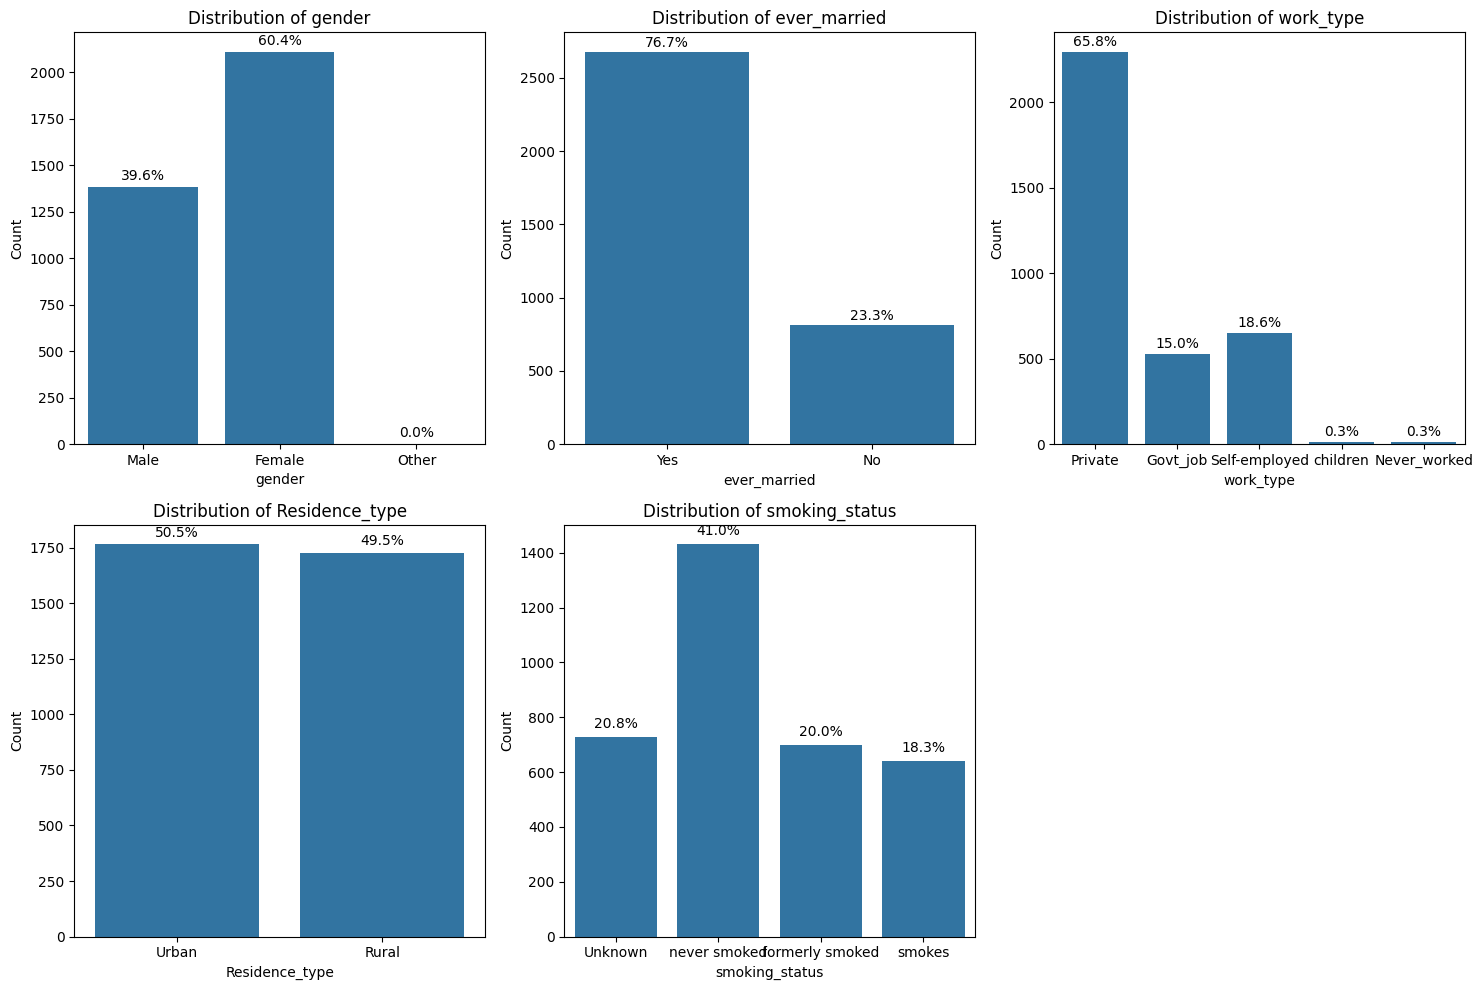

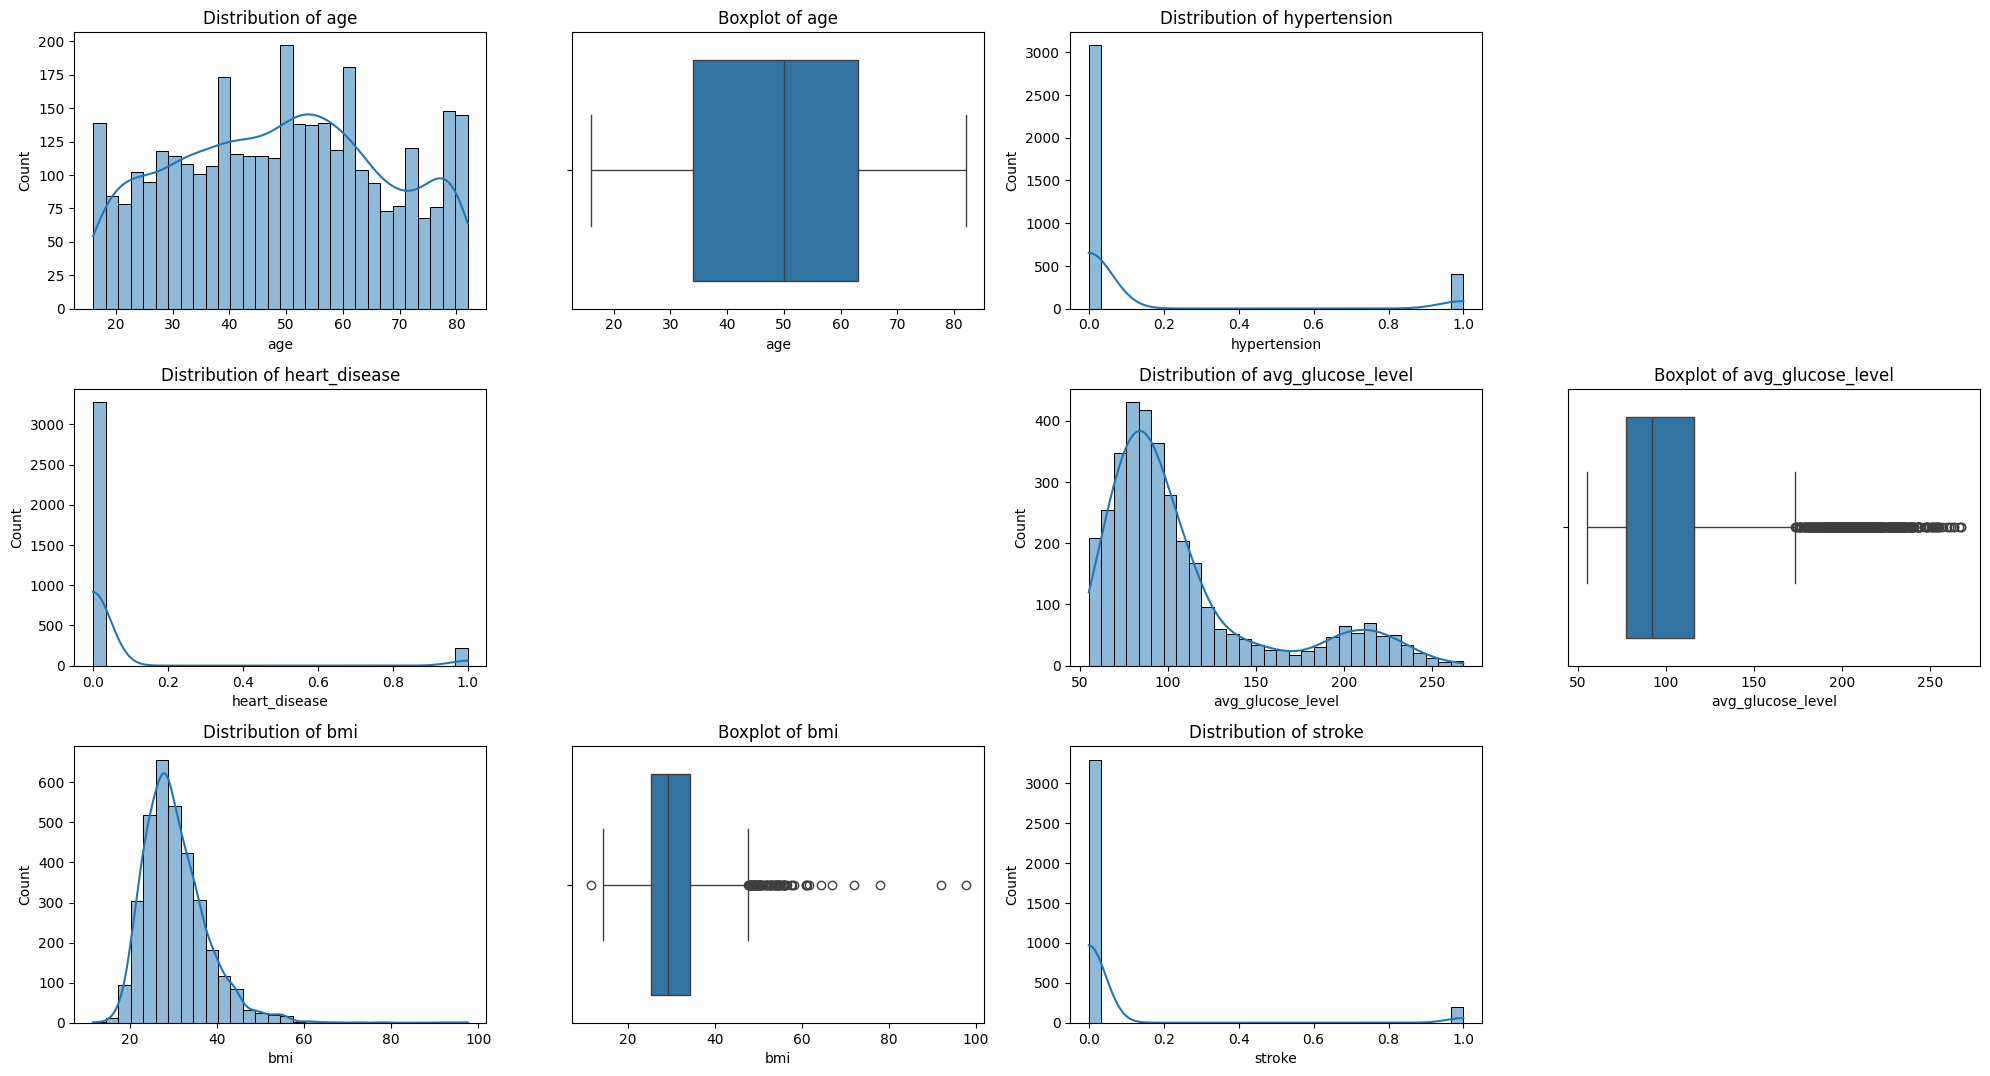

In [13]:
columns_to_plot = training_data.select_dtypes(
    include=["object", "category", "bool"]
).columns.tolist()

plt.figure(figsize=(15, 5 * ((len(columns_to_plot) + 2) // 3)))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot((len(columns_to_plot) + 2) // 3, 3, i)

    sns.countplot(x=col, data=training_data)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

    total = len(training_data)
    for p in plt.gca().patches:
        height = p.get_height()
        plt.gca().text(
            p.get_x() + p.get_width() / 2.0,
            height + 0.01 * total,
            f"{height/total:.1%}",
            ha="center",
        )

plt.tight_layout()
plt.show()

features = training_data.select_dtypes(include=["int64", "float64"]).columns.tolist()

features = [col for col in features if col not in ["CustomerID", "ID"]]

n_cols = 4
n_rows = int(len(features) * 2 / n_cols) + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3.5))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.histplot(training_data[col], kde=True, bins=30, ax=axes[2 * i])
    axes[2 * i].set_title(f"Distribution of {col}")

    if training_data[col].nunique() > 2:
        sns.boxplot(x=training_data[col], ax=axes[2 * i + 1])
        axes[2 * i + 1].set_title(f"Boxplot of {col}")
    else:
        axes[2 * i + 1].remove()

for j in range(2 * len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

As seen below, the same trend continues when we cross-check each feature by stroke. Namely, there seem to be a variety of groups with a very small amount of examples, which will likely be an issue for later models.

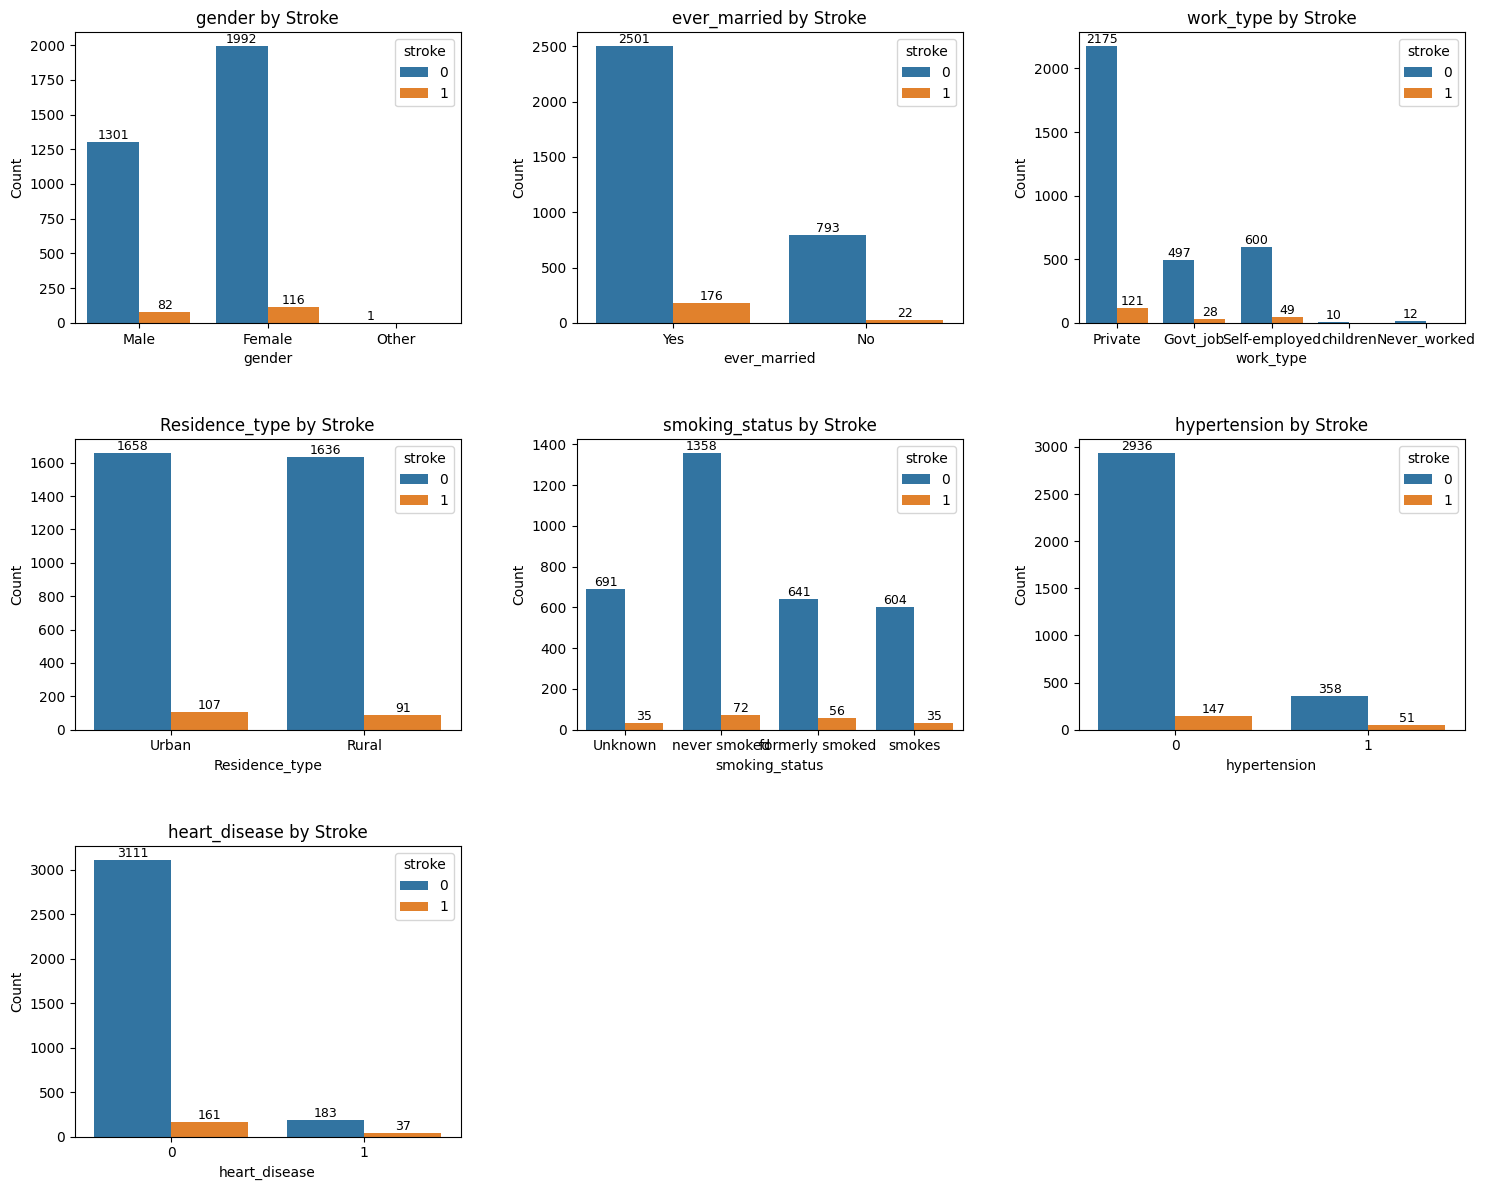

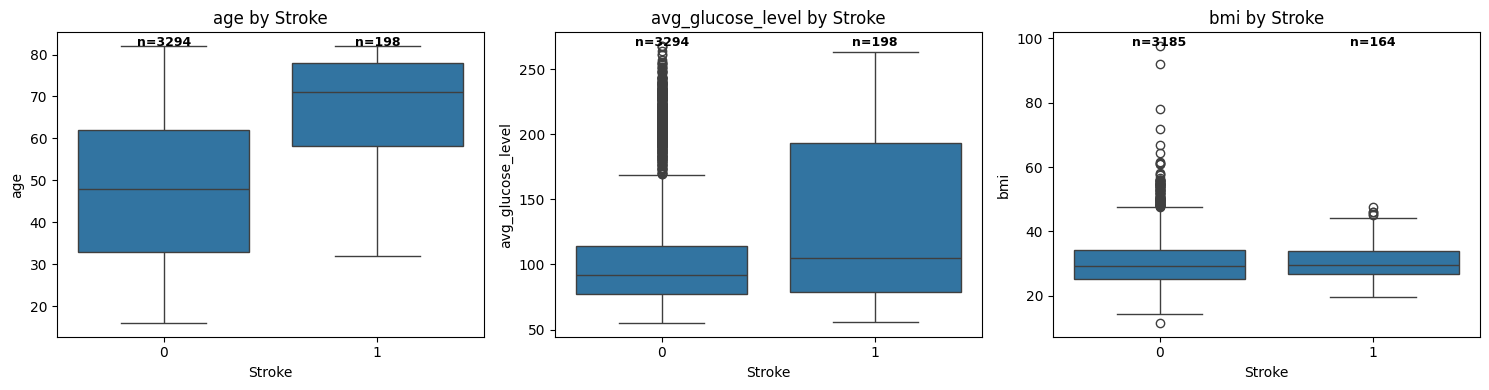

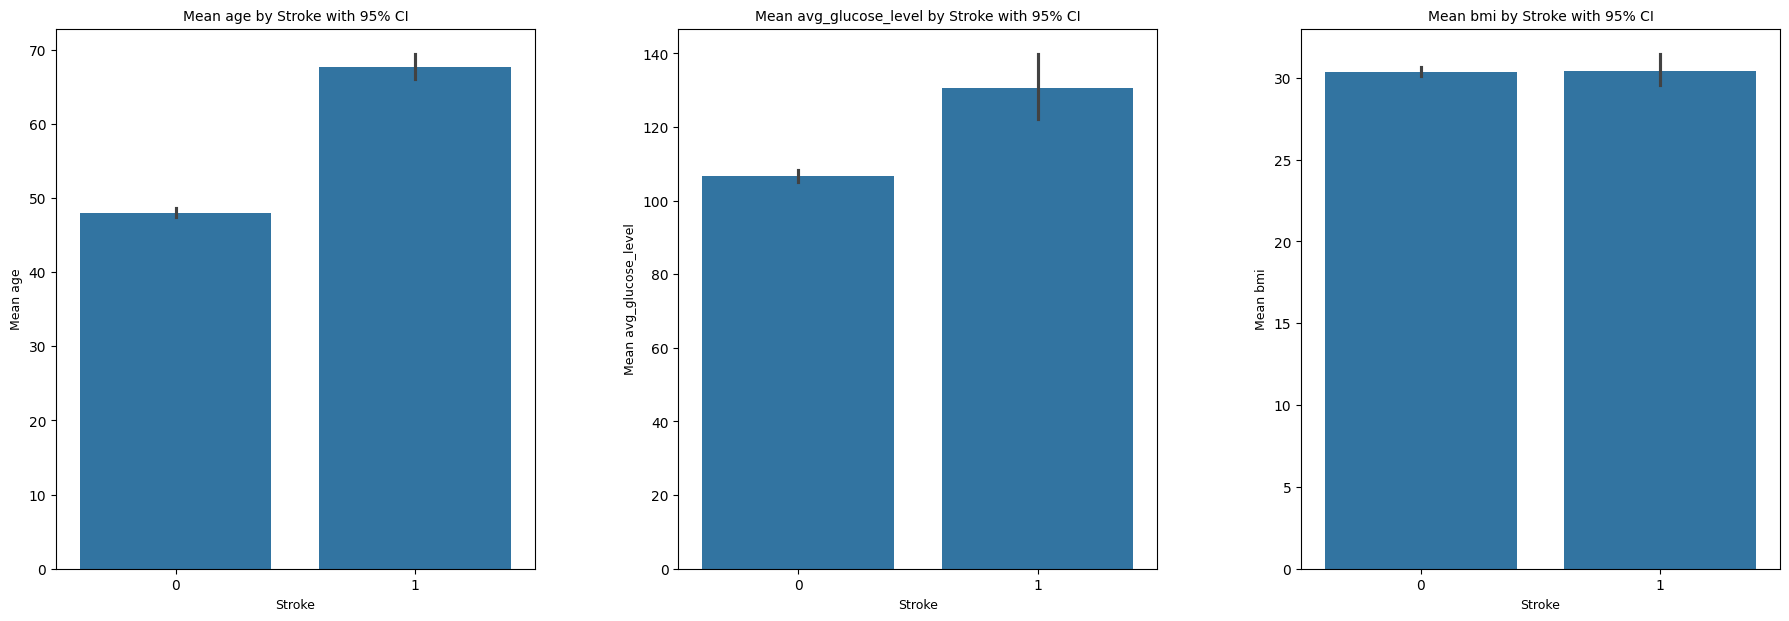

In [14]:
cat_columns = training_data.select_dtypes(
    include=["object", "category", "bool"]
).columns.tolist()

num_columns = training_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_columns = [
    col for col in num_columns if col.lower() not in ["id", "customerid", "stroke"]
]
binary_cols = [col for col in num_columns if training_data[col].nunique() == 2]

combined_columns = cat_columns + binary_cols
combined_columns = [col for col in combined_columns if col != "stroke"]

n_cols = 3
n_rows = (len(combined_columns) // n_cols) + int(len(combined_columns) % n_cols != 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(combined_columns):
    ax = axes[i]
    sns.countplot(x=col, hue="stroke", data=training_data, ax=ax)
    ax.set_title(f"{col} by Stroke")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(
                f"{int(height)}",
                (p.get_x() + p.get_width() / 2, height),
                ha="center",
                va="bottom",
                fontsize=9,
                color="black",
            )

for j in range(len(combined_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()


continuous_cols = [col for col in num_columns if training_data[col].nunique() > 2]

n_cols = 3
n_rows = (len(continuous_cols) // n_cols) + int(len(continuous_cols) % n_cols != 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    ax = axes[i]
    sns.boxplot(x="stroke", y=col, data=training_data, ax=ax)
    ax.set_title(f"{col} by Stroke")
    ax.set_xlabel("Stroke")
    ax.set_ylabel(col)
    counts = training_data.groupby("stroke")[col].count()
    for stroke_val, count in counts.items():
        ax.text(
            stroke_val,
            training_data[col].max(),
            f"n={count}",
            horizontalalignment="center",
            color="black",
            fontsize=9,
            weight="bold",
        )

for j in range(len(continuous_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

n_cols = 3
n_rows = (len(continuous_cols) // n_cols) + int(len(continuous_cols) % n_cols != 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    ax = axes[i]
    sns.barplot(x="stroke", y=col, data=training_data, errorbar=('ci', 95), ax=ax)
    ax.set_title(f"Mean {col} by Stroke with 95% CI", fontsize=10)
    ax.set_xlabel("Stroke", fontsize=9)
    ax.set_ylabel(f"Mean {col}", fontsize=9)

for j in range(len(continuous_cols), len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.6, wspace=0.3)
plt.show()


## Checking for Multicollinearity
Next I check for multicollinearity. To do that, I must first one-hot encode all the variables which are not numeric, as well as use data imputation to fill the NaN values from the 'bmi' column, as earlier identified.

Then, I create a heat map to see if any different variables are highly correlated. As can be seen, there are a few variables which seem noticeably correlated. However, a VIF test shows this to not be anything of note. Consequently, there are no factors which are too correlated with one another.

In [15]:
non_numeric_cols = training_data.select_dtypes(exclude=["number"]).columns
encoded_training_data = pd.get_dummies(
    training_data, columns=non_numeric_cols, drop_first=True
)
bool_cols = encoded_training_data.select_dtypes(include=["bool"]).columns
encoded_training_data[bool_cols] = encoded_training_data[bool_cols].astype(int)

imputer = SimpleImputer(strategy="mean")
numeric_cols = encoded_training_data.select_dtypes(include=["number"]).columns
encoded_training_data[numeric_cols] = imputer.fit_transform(
    encoded_training_data[numeric_cols]
)
encoded_training_data.columns = [
    col.replace(" ", "_") for col in encoded_training_data.columns
]
encoded_training_data.columns = [
    col.replace("-", "_") for col in encoded_training_data.columns
]
encoded_training_data

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self_employed,work_type_children,Residence_type_Urban,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,,
5686,35.0,0.0,0.0,69.88,27.7,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
61838,50.0,0.0,0.0,128.63,23.1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31835,19.0,0.0,0.0,74.86,28.4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
63323,49.0,1.0,0.0,119.30,30.4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
22295,25.0,0.0,0.0,82.77,36.3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,46.0,0.0,0.0,85.84,21.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
56735,78.0,0.0,0.0,115.43,27.8,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
23094,65.0,0.0,0.0,105.61,27.9,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


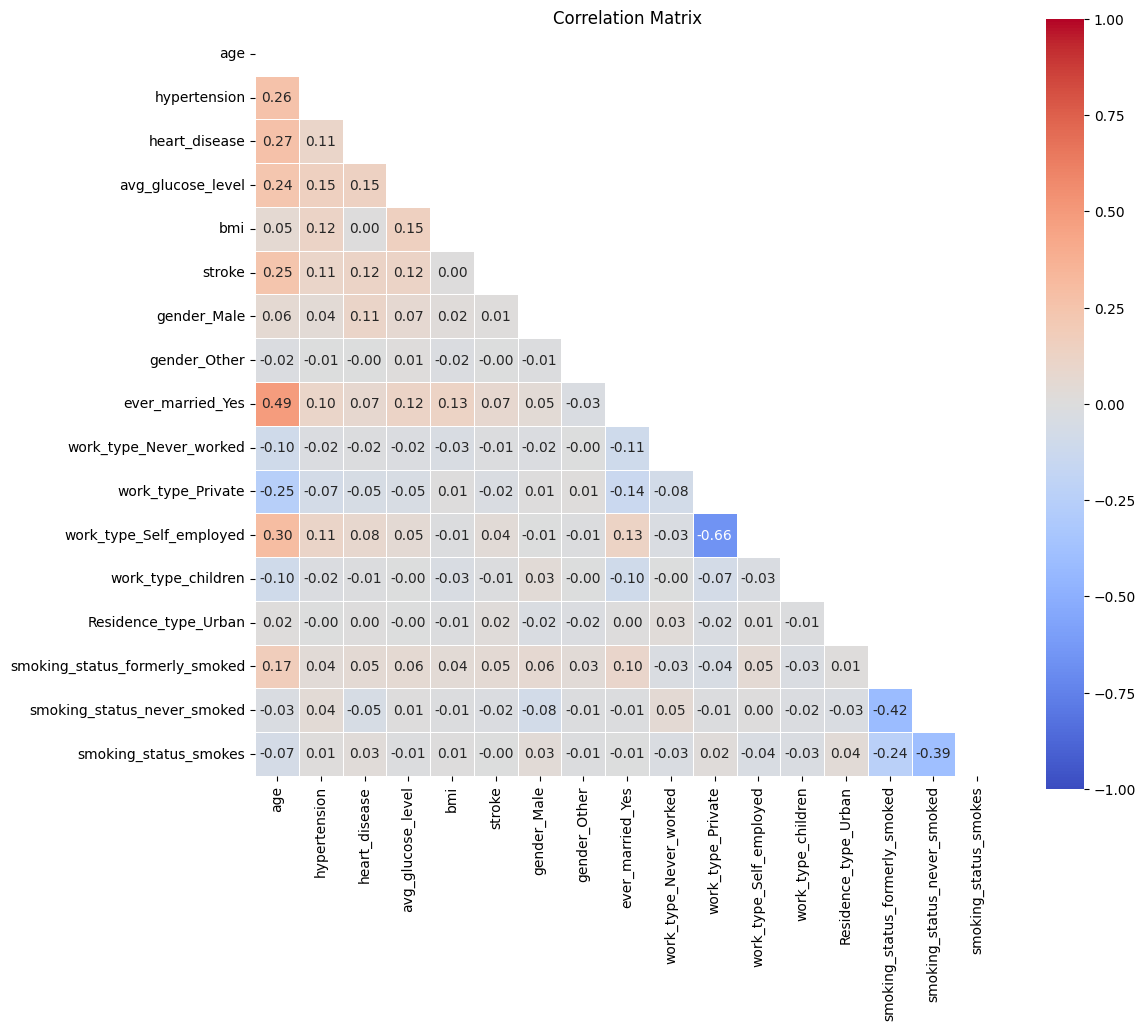

In [16]:
corr = encoded_training_data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    square=True,
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)
plt.title("Correlation Matrix")
plt.show()

In [17]:
X = encoded_training_data.drop("stroke", axis=1)

X_with_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_with_const.values, i)
    for i in range(X_with_const.shape[1])
]

print(vif_data)

                          Variable        VIF
0                            const  39.699008
1                              age   1.688333
2                     hypertension   1.106862
3                    heart_disease   1.109172
4                avg_glucose_level   1.101675
5                              bmi   1.051459
6                      gender_Male   1.027313
7                     gender_Other   1.003779
8                 ever_married_Yes   1.360765
9           work_type_Never_worked   1.041671
10               work_type_Private   1.868194
11         work_type_Self_employed   1.882336
12              work_type_children   1.041115
13            Residence_type_Urban   1.005124
14  smoking_status_formerly_smoked   1.624943
15     smoking_status_never_smoked   1.789485
16           smoking_status_smokes   1.560666


## Standardizing the Data
Next I standardize the data so that it can better be studied in an inferential logistic regression.

In [18]:
df = encoded_training_data.copy()

for col in continuous_cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

In [19]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self_employed,work_type_children,Residence_type_Urban,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,,
5686,-0.770211,0.0,0.0,-0.808182,-0.372336,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
61838,0.046859,0.0,0.0,0.435577,-1.013091,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31835,-1.641752,0.0,0.0,-0.702753,-0.274829,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
63323,-0.007612,1.0,0.0,0.238057,0.003760,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
22295,-1.314924,0.0,0.0,-0.535296,0.825598,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


# Running a Logistic Regression to Investigate Coefficients
Next I run a logistic regression to build an inferential model and further understand the validity of each coefficient in later building a predictive model. However, many of these groups have almost data in them. An (over)simplified heuristic is that we should have about 10 cases in each group, and as earlier exemplified, this is not at all the case. We could consider using SMOTE or oversampling, but as many of our variables are the binary case, these cannot be resampled according to SMOTE, as it creates a point that is between two of the case points, which is impossible in the case of a binary variable (we cannot have half of a heart disease, for example). As such, I have decided to just leave things as is, and take this into account in the evaluation of the model

In [20]:
target = "stroke"
predictors = df.columns.drop(target)

formula = f"{target} ~ {' + '.join(predictors)}"

model = logit(formula, data=df).fit()

print(model.summary())

         Current function value: 0.179780
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 3492
Model:                          Logit   Df Residuals:                     3475
Method:                           MLE   Df Model:                           16
Date:                Mon, 23 Jun 2025   Pseudo R-squ.:                  0.1745
Time:                        23:17:27   Log-Likelihood:                -627.79
converged:                      False   LL-Null:                       -760.53
Covariance Type:            nonrobust   LLR p-value:                 3.421e-47
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -3.6265      0.365     -9.925      0.000      -4.343      -2.910
age  

C:\Users\david\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Based on the results, only two predictors seem to be significant, namely Age (p < 0.001) and average glucose level (p < 0.05).
As these are the only ones that are significant, I rerun the model without the remaining ones in order to specify the coefficients further.

In [21]:
significant_vars = [
    "age",
    "avg_glucose_level",
]

formula = f"{target} ~ {' + '.join(significant_vars)}"

model = logit(formula, data=df).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.182045
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 3492
Model:                          Logit   Df Residuals:                     3489
Method:                           MLE   Df Model:                            2
Date:                Mon, 23 Jun 2025   Pseudo R-squ.:                  0.1641
Time:                        23:17:28   Log-Likelihood:                -635.70
converged:                       True   LL-Null:                       -760.53
Covariance Type:            nonrobust   LLR p-value:                 6.135e-55
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.5563      0.127    -28.076      0.000      -3.805      -3.308
age     

Firstly, the LLR *p*-value of 6.135 * e^68 indicates that the model as a whole is significant.

The same three variables remain significant to the same degree:
- **Age** (*p* < 0.001, β = 1.3182). This shows that with every unit increase in age, the log odds of having had a stroke increases by 1.3182. 
- **Average Glucose Level** (*p* < 0.05, β = 0.1871). This shows that with every unit increase in average glucose level, the log odds of having had a stroke increases by 0.1871.

Moreover, the McFadden's Pseudo R-Squared value of 0.1641 shows that about 16.4% of the variance in the dataset can be explained through the included variables, which is not bad for only three variables.

# Assumptions of the Model
Next I quickly check the assumptions of the model to ensure that these results warrant trust

## Multicollinearity
As the VIF score showed earlier, none of the variables were significantly correlated with one another - thus upholding this assumption.

## Adequately Large Sample Size
As discussed earlier, there are several groups that are quite low in sample size. However, to preserve the already small number of cases in the minority, I do not drop them, and I do not use techniques like SMOTE, as they cannot apply to the minority cases.
However, the issue of them being present in the dataset is not really material, as they do not constitute significant variables, and are cut in the calibrated model to reduce noise anyway.

## Linear Logit Function in Continuous Variables
Next I check whether the logit function is linear for the continuous variables. Namely, I check whether the explanatory models and the logit of the response variable have a linear relationship - this assumption is upheld.

In [22]:
for predictor in ["age", "avg_glucose_level"]:
    df[f"{predictor}_squared"] = df[predictor] * df[predictor]

    formula = f"stroke ~ {predictor} + {predictor}_squared"
    model = logit(formula, data=df).fit()

    print(f"Box-Tidwell test for {predictor}:")
    print(model.summary())

Optimization terminated successfully.
         Current function value: 0.182793
         Iterations 10
Box-Tidwell test for age:
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 3492
Model:                          Logit   Df Residuals:                     3489
Method:                           MLE   Df Model:                            2
Date:                Mon, 23 Jun 2025   Pseudo R-squ.:                  0.1607
Time:                        23:17:28   Log-Likelihood:                -638.31
converged:                       True   LL-Null:                       -760.53
Covariance Type:            nonrobust   LLR p-value:                 8.340e-54
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.4887      0.134    -26.008      0.000      -3.752      -3.226

## No Outliers
As seen earlier in the boxplot, there were outliers. However, I decided to keep these in the model, given the low amount of cases we have in the minority case already.

## Independent Observations
From our perspective, we can assume the independence of observations, as they ostensibly would be so. However, as we are not familiar with how the data was sampled, we cannot speak too confidently to this point.

# Conclusion from Inferential Model and Preliminary Insights into ML Model
This inferential model indicates that two variable of age and average glucose level are significant variables, and as such the other variables might benefit from regularization to optimize model performance and prevent overfitting, as will be investigated later. The inferential model violated an assumption. But rather than focusing too much on this, I move on to ML models, as that is the main topic of this report.

The hypothesis of age being the most impactful and significant predictor of whether someone has had a stroke thereby receives support. However, the remaining hypotheses, namely that having a heart disease, hypertension, or being a smoker positively predicts having had a stroke, does not receive support.

Furthermore, the exploratory data analysis also shows that the non-presence of outliers and  multicollinearity bodes well for future investigation. 

Also, it is important to note how some of the variables are quite noticeably skewed, both in terms of our predictor features and the target variable itself. This will be discussed further next.

# Building and Comparing Different ML Models
Next, I seek to build a predictive model that can reliably predict whether a user buys the insurance, and as such serve as a predictive tool for future customers and demographics. In doing this, I first build a pipeline to...
- Scale the continuous variables using RobustScaler() to get more precise coefficients
- One-hot encode all the non-binary categorical variables
- Data Impute the mean for the missing NaN values - in this case, in the 'bmi' column

In [23]:
def get_column_types(df):
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]
    categorical_cols = [
        col
        for col in df.columns
        if 2 < df[col].nunique() <= 10
        and (df[col].dtype == "object" or np.issubdtype(df[col].dtype, np.number))
    ]
    continuous_cols = [
        col
        for col in df.select_dtypes(include=["float64", "int64"]).columns
        if col not in binary_cols + categorical_cols
    ]
    return continuous_cols, categorical_cols, binary_cols


cont_cols, cat_cols, bin_cols = get_column_types(X_train)

cont_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", RobustScaler())]
)

cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]
)

bin_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cont", cont_transformer, cont_cols),
        ("cat", cat_transformer, cat_cols),
        ("bin", bin_transformer, bin_cols),
    ]
)

## Testing Models
Next I test a variety of different models. In doing this, I will be evaluating each with a range of different metrics, but I will primarily be evaluating them in terms of the recall score of the positive case of strokes, as well as its F1 score. That is to say, I will mainly compare different models by the extent to which they can accurately predict the **existence** (not the non-existence) of a stroke in a patient.
While I do not belong to a medical institution with specific data targets in mind, which would otherwise take precedence, I regardless make the judgement to choose this as the main evaluator for this analysis. I would argue that, at least ostensibly, this makes the most sense from a care-perspective, given that anyone with a high-risk of a stroke ought to seek medical attention, as opposed to those who are not.

### How Things Look with a Stratified Dummy Classifier
As seen below, the F1 score of a positive prediction of stroke is 0.04 under a stratified dummy classifier. However, as we can also see, the F1 score is 0.95 for negative cases, which goes to show the imbalance of the different cases.

This is a low bar to break! Our models will likely be able to do a better job.

In [24]:
dummy_strat = DummyClassifier(strategy="stratified", random_state=42)
dummy_strat.fit(X_train, y_train)
y_strat_pred = dummy_strat.predict(X_test)
y_strat_proba = dummy_strat.predict_proba(X_test)[:, 1]

print("\nDummy Classifier (stratified):")
print(classification_report(y_test, y_strat_pred))
print(f"Test AUC: {roc_auc_score(y_test, y_strat_proba):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_strat_pred):.3f}")


Dummy Classifier (stratified):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       825
           1       0.04      0.04      0.04        49

    accuracy                           0.89       874
   macro avg       0.49      0.49      0.49       874
weighted avg       0.89      0.89      0.89       874

Test AUC: 0.491
Test Accuracy: 0.890


### Creating Functions for Models
Below I create a few functions which are important for the ML models. This just helps clean up repetitive code.

In [25]:
def evaluate_model_performance(y_test, y_pred, y_proba, class_labels=None):
    """
    Prints evaluation metrics and plots confusion matrix and ROC curve.

    Parameters:
        y_test (array-like): True labels.
        y_pred (array-like): Predicted class labels.
        y_proba (array-like): Predicted probabilities for the positive class.
        class_labels (list): Labels for confusion matrix axes.
    """
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print(f"\nTest AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

    class_labels = list(np.unique(y_test))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


def plot_learning_curve(
    model, X, y, scoring="average_precision", cv=5, title="Learning Curve"
):
    """
    Plots a learning curve showing training and validation scores.

    Parameters:
        model: Fitted estimator or pipeline.
        X (array-like): Feature matrix.
        y (array-like): Target labels.
        scoring (str): Scoring metric to evaluate (default: "average_precision").
        cv (int or cross-validation generator): Number of CV folds or CV strategy.
        title (str): Title for the plot.
    """
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1,
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, "o-", color="blue", label="Training score")
    plt.fill_between(
        train_sizes,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.1,
        color="blue",
    )

    plt.plot(train_sizes, val_mean, "o-", color="green", label="Validation score")
    plt.fill_between(
        train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="green"
    )

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{scoring.replace('_', ' ').title()} Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def get_feature_names(preprocessor):
    """
    This function retrieves the original continuous and binary feature names,
    and combines them with the one-hot encoded categorical feature names from the preprocessing pipeline.

    Parameters:
        preprocessor (ColumnTransformer):
            A fitted scikit-learn ColumnTransformer object that includes:
            - a "cat" transformer for categorical columns with a named step "onehot"
            - transformations for continuous (`cont_cols`) and binary (`bin_cols`) columns passed through
    """
    cont_bin_cols = cont_cols + bin_cols
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_features = ohe.get_feature_names_out(cat_cols)
    return np.concatenate([cont_bin_cols, cat_features])

### Logistic Regression Model

As seen below, a logistic regression model gives an:
- *Positive Case Precision =  0.15*. This is a poor figure
- *Positive Case Recall = 0.86*. This is a very good figure.
- *Positive Case F1 = 0.25.* This is a poor figure, but mostly due to the precision.

We could, of course, seek to increase precision at the cost of recall, such as by reducing the threshold by which a case gets assigned to the case, adding class weights to this specific case to penalize the model more when getting this specific case wrong, or by resampling the underrepresented case (e.g., through SMOTE)**. However, I do not want to sacrifice recall, as this is arguably the most important metric. I also cannot really use SMOTE, as it does not function well on non-binary cases. In addition, SMOTE and oversampling stand a great chance of causing overfitting, given how few cases we have. Besides, I should say that I tried some of these methods, and faced no significant increases in values.

Here, the coefficients which are shown to hold the highest influence to be age, with the remaining factors following far behind, as shown by the SHapley chart. This also shows support for the hypothesis. 

Performing randomized search with cross-validation...

Best parameters found:
{'classifier__C': np.float64(0.5622117123602399), 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Best cross-validation F1 score: 0.228


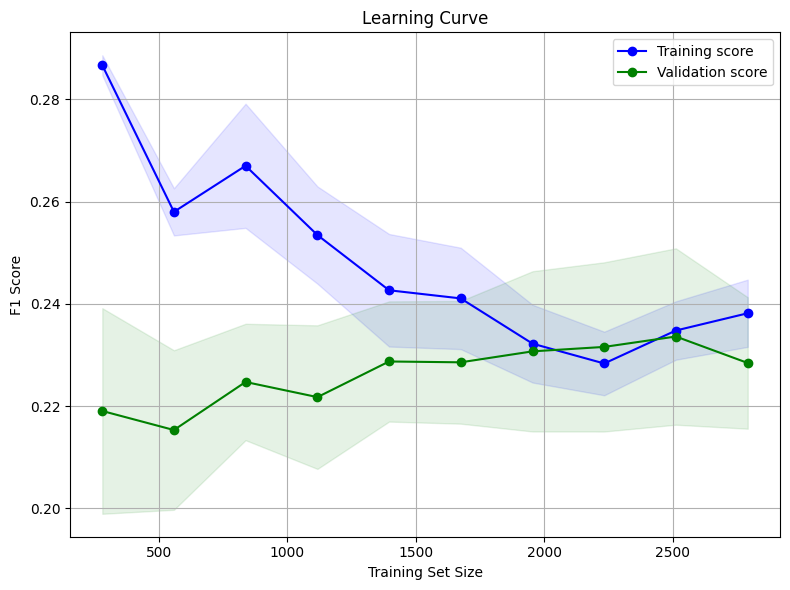


Prediction distribution:
0    586
1    288
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       825
           1       0.15      0.86      0.25        49

    accuracy                           0.71       874
   macro avg       0.57      0.78      0.53       874
weighted avg       0.94      0.71      0.79       874


Test AUC: 0.849
Test Accuracy: 0.711


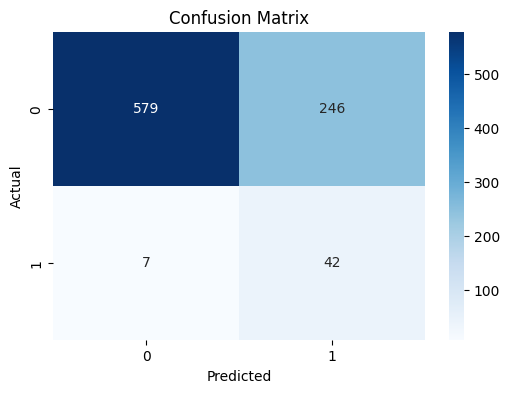

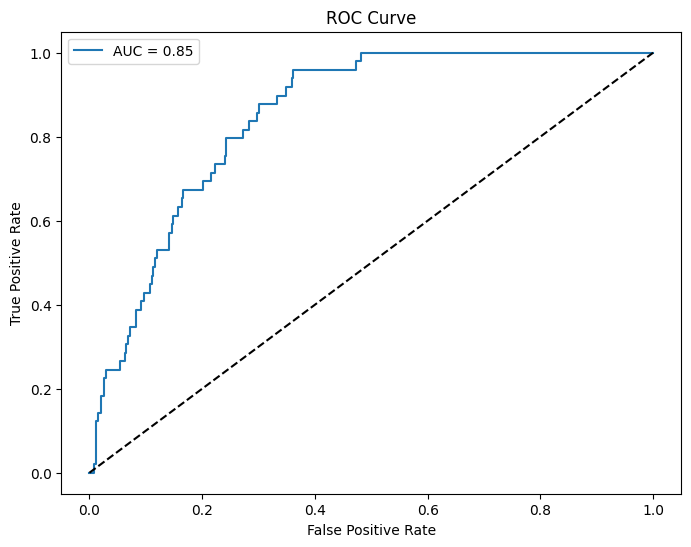


Feature Coefficients:
                           Feature  Coefficient
0                              age     2.223622
15          smoking_status_Unknown     0.361562
16  smoking_status_formerly smoked     0.248004
8                      gender_Male     0.180370
14              work_type_children     0.152028
1                avg_glucose_level     0.139821
18           smoking_status_smokes     0.056837
2                              bmi     0.032461
3                     hypertension     0.000000
6                   Residence_type     0.000000
5                     ever_married     0.000000
12               work_type_Private     0.000000
17     smoking_status_never smoked     0.000000
7                    gender_Female     0.000000
10              work_type_Govt_job     0.000000
4                    heart_disease    -0.134040
9                     gender_Other    -0.200517
11          work_type_Never_worked    -0.205814
13         work_type_Self-employed    -0.351763

Running SHAP ana

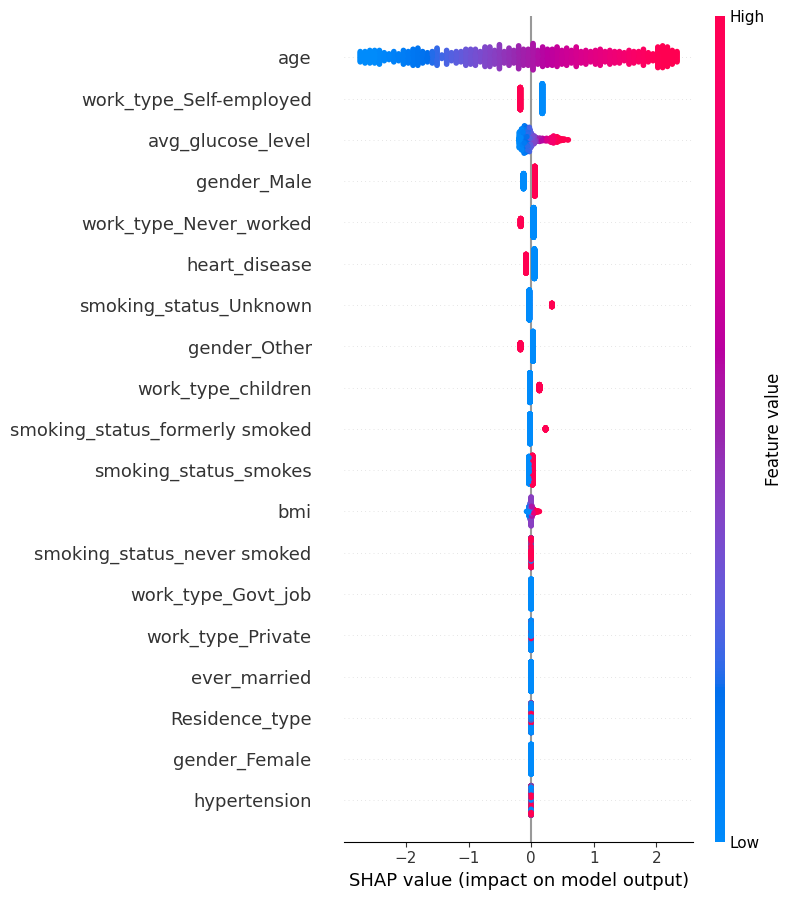

In [26]:
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced"),
        ),
    ]
)

param_dist = {
    "classifier__C": uniform(0.01, 100),
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear"],
}

print("Performing randomized search with cross-validation...")
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5),
    scoring="f1",
    n_jobs=-1,
    random_state=42,
)
random_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation F1 score: {random_search.best_score_:.3f}")

best_model = random_search.best_estimator_

plot_learning_curve(best_model, X_train, y_train, scoring="f1", title="Learning Curve")

y_pred = best_model.predict(X_test)
print("\nPrediction distribution:")
print(pd.Series(y_pred).value_counts())

y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Stroke", "Stroke"]
)

feature_names = get_feature_names(best_model.named_steps["preprocessor"])
coefficients = best_model.named_steps["classifier"].coef_[0]
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
print("\nFeature Coefficients:")
print(coef_df.sort_values("Coefficient", ascending=False))

print("\nRunning SHAP analysis...")

X_test_transformed = best_model.named_steps["preprocessor"].transform(X_test)

explainer = shap.LinearExplainer(
    best_model.named_steps["classifier"], X_test_transformed
)

shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

### Decision Tree Model

As seen below, a decision tree model gives an:
- *Positive Case Precision =  0.13*. This is a very poor figure
- *Positive Case Recall = 0.88*. This is a very good figure.
- *Positive Case F1 = 0.23.* This is a poor figure, but mostly due to the precision.

Here, the coefficients which are shown to hold the highest influence to be age, with the remaining factors following far behind, though not quite to as large a degree as in the logistic model. This also shows support for the hypothesis. 

Performing randomized search with cross-validation...

Best parameters found:
{'classifier__max_depth': 4, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 13}

Best cross-validation score: 0.226


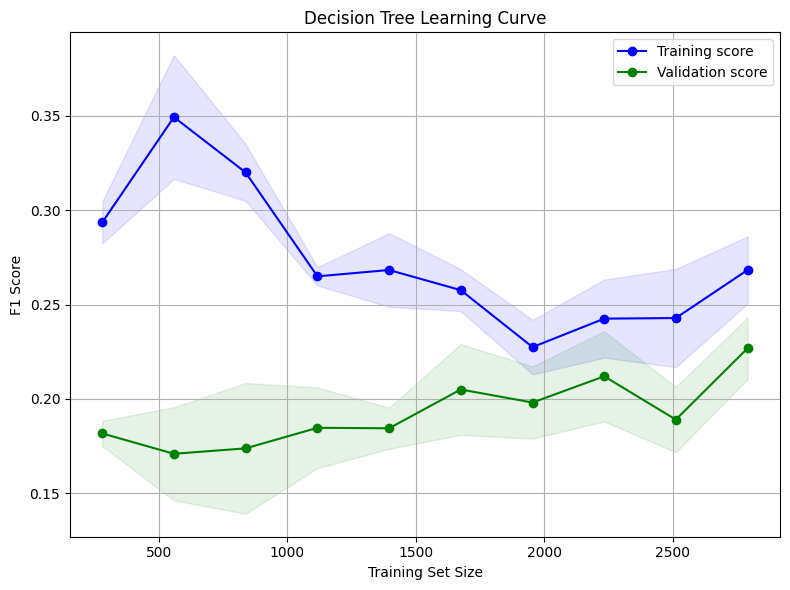


Prediction distribution:
0    552
1    322
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       825
           1       0.13      0.88      0.23        49

    accuracy                           0.67       874
   macro avg       0.56      0.77      0.51       874
weighted avg       0.94      0.67      0.76       874


Test AUC: 0.800
Test Accuracy: 0.674


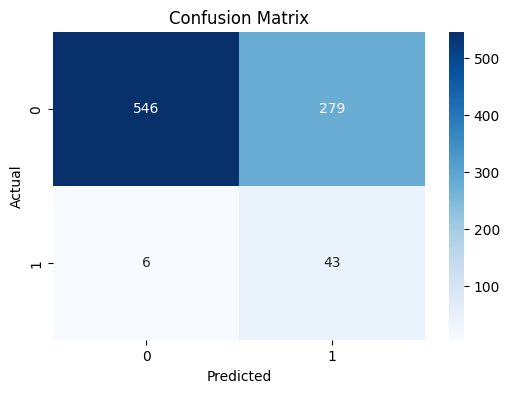

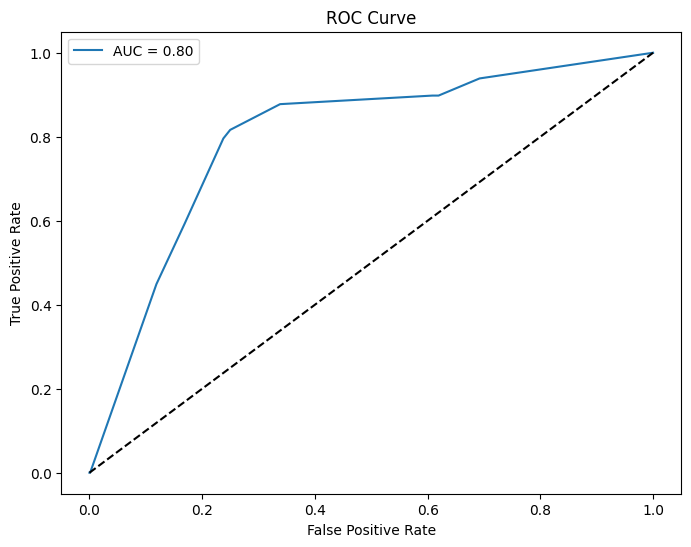


Feature Importances:
                           Feature  Importance
0                              age    0.823350
1                avg_glucose_level    0.109518
13         work_type_Self-employed    0.053602
2                              bmi    0.011970
14              work_type_children    0.001559
3                     hypertension    0.000000
4                    heart_disease    0.000000
7                    gender_Female    0.000000
8                      gender_Male    0.000000
5                     ever_married    0.000000
6                   Residence_type    0.000000
10              work_type_Govt_job    0.000000
9                     gender_Other    0.000000
12               work_type_Private    0.000000
11          work_type_Never_worked    0.000000
15          smoking_status_Unknown    0.000000
16  smoking_status_formerly smoked    0.000000
17     smoking_status_never smoked    0.000000
18           smoking_status_smokes    0.000000


In [27]:
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            DecisionTreeClassifier(random_state=42, class_weight="balanced"),
        ),
    ]
)

param_dist = {
    "classifier__max_depth": randint(2, 20),
    "classifier__min_samples_split": randint(2, 20),
    "classifier__min_samples_leaf": randint(1, 20),
}

print("Performing randomized search with cross-validation...")
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5),
    scoring="f1",
    n_jobs=-1,
    random_state=42,
)

random_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {random_search.best_score_:.3f}")

best_model = random_search.best_estimator_
plot_learning_curve(
    best_model, X_train, y_train, scoring="f1", title="Decision Tree Learning Curve"
)
y_pred = best_model.predict(X_test)
print("\nPrediction distribution:")
print(pd.Series(y_pred).value_counts())
y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Stroke", "Stroke"]
)

feature_names = get_feature_names(best_model.named_steps["preprocessor"])
importances = best_model.named_steps["classifier"].feature_importances_

importances_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

print("\nFeature Importances:")
print(importances_df)

### Support Vector Machine Model
As seen below, the SVC gives a:
- *Positive Case Precision =  0.15*. This is a very poor figure
- *Positive Case Recall = 0.90*. This is a very good figure.
- *Positive Case F1 = 0.26.* This is a poor figure, but mostly due to the precision.

Here, the coefficients which are shown to hold the highest influence to be age.

Note: I used random search to tune for hyperparameters, but in the final code below I have not displayed this to speed up training time.

Performing randomized search with cross-validation...

Best parameters found:
{'classifier__C': np.float64(82.88375091519293), 'classifier__class_weight': 'balanced', 'classifier__degree': 2, 'classifier__gamma': 'auto', 'classifier__kernel': 'linear'}

Best cross-validation score: 0.226


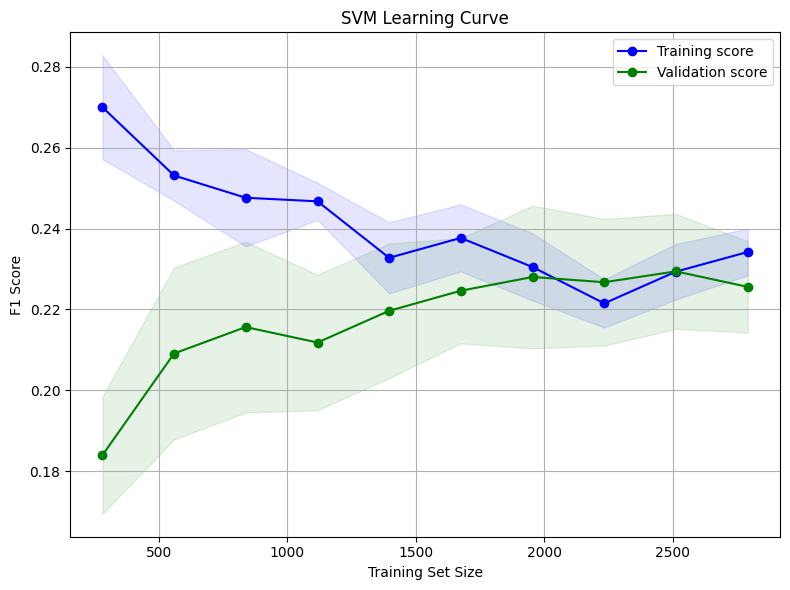


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.69      0.82       825
           1       0.15      0.90      0.26        49

    accuracy                           0.71       874
   macro avg       0.57      0.80      0.54       874
weighted avg       0.94      0.71      0.79       874


Test AUC: 0.852
Test Accuracy: 0.706


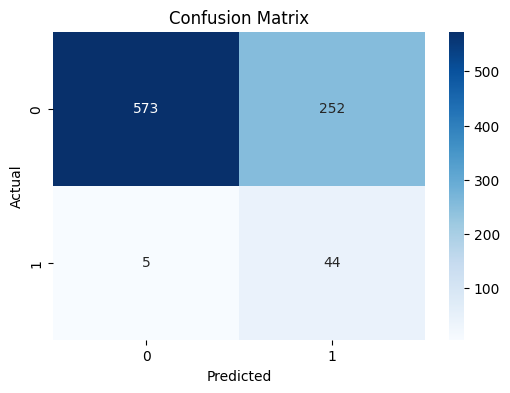

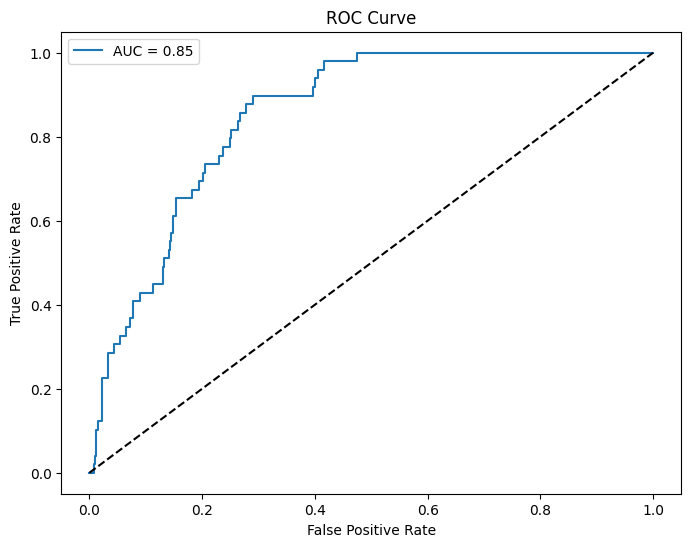


Feature Coefficients:
                           Feature  Coefficient
0                              age     1.774350
15          smoking_status_Unknown     0.271782
14              work_type_children     0.269419
16  smoking_status_formerly smoked     0.243792
12               work_type_Private     0.147718
1                avg_glucose_level     0.127709
8                      gender_Male     0.092480
18           smoking_status_smokes     0.085043
2                              bmi     0.049948
3                     hypertension     0.024934
7                    gender_Female     0.000000
5                     ever_married     0.000000
10              work_type_Govt_job     0.000000
4                    heart_disease    -0.024934
9                     gender_Other    -0.040888
6                   Residence_type    -0.051592
17     smoking_status_never smoked    -0.166677
11          work_type_Never_worked    -0.196860
13         work_type_Self-employed    -0.220278


In [28]:
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", SVC(kernel="linear", class_weight="balanced", probability=True, random_state=42)),
    ]
)

param_dist = {
    "classifier__kernel": ["linear", "rbf", "poly"],
    "classifier__C": uniform(0.01, 100),
    "classifier__gamma": ["scale", "auto"],
    "classifier__class_weight": [None, "balanced"],
    "classifier__degree": randint(2, 5), 
}

print("Performing randomized search with cross-validation...")
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5),
    scoring="f1",
    n_jobs=-1,
    random_state=42,
)

random_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {random_search.best_score_:.3f}")

best_model = random_search.best_estimator_

plot_learning_curve(
    best_model,
    X_train,
    y_train,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5),
    title="SVM Learning Curve",
)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Insurance", "Insurance"]
)

if best_model.named_steps["classifier"].kernel == "linear":
    feature_names = get_feature_names(best_model.named_steps["preprocessor"])
    coefficients = best_model.named_steps["classifier"].coef_[0]

    coef_df = pd.DataFrame(
        {"Feature": feature_names, "Coefficient": coefficients}
    ).sort_values("Coefficient", ascending=False)

    print("\nFeature Coefficients:")
    print(coef_df)
else:
    print("\nFeature coefficients are only available for linear kernel")
    print("Selected kernel:", best_model.named_steps["classifier"].kernel)


### Naive Bayes Model
As seen below, the Naive Bayed model gives a:
- *Positive Case Precision =  0.21*. This is a very poor figure
- *Positive Case Recall = 0.35*. This is a poor figure.
- *Positive Case F1 = 0.26.* This is a poor figure, but mostly due to the precision.

Here, the coefficients which are shown to hold the highest influence to be age,  with the rest trailing quite far behind.

Performing randomized search with cross-validation...

Best parameters found:
{'classifier__var_smoothing': np.float64(0.02310129700083159)}

Best cross-validation AUC score: 0.225

Evaluating on test set...

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       825
           1       0.21      0.35      0.26        49

    accuracy                           0.89       874
   macro avg       0.58      0.63      0.60       874
weighted avg       0.92      0.89      0.90       874


Test AUC: 0.829
Test Accuracy: 0.889


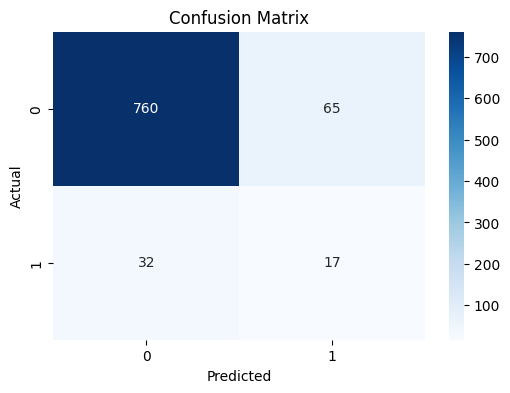

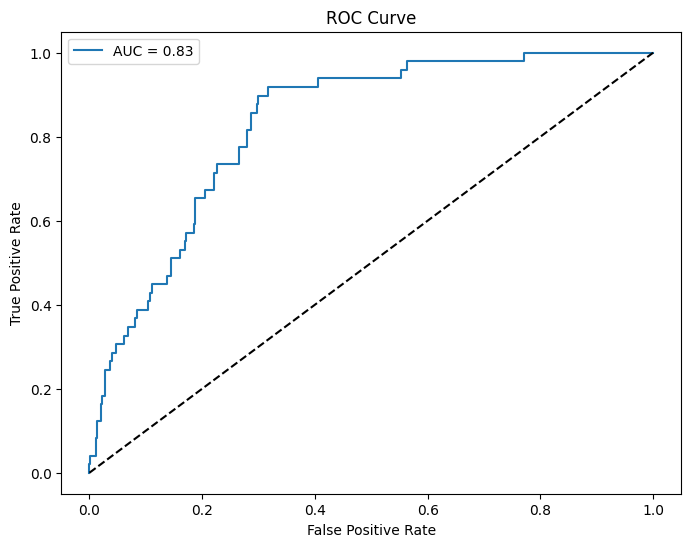

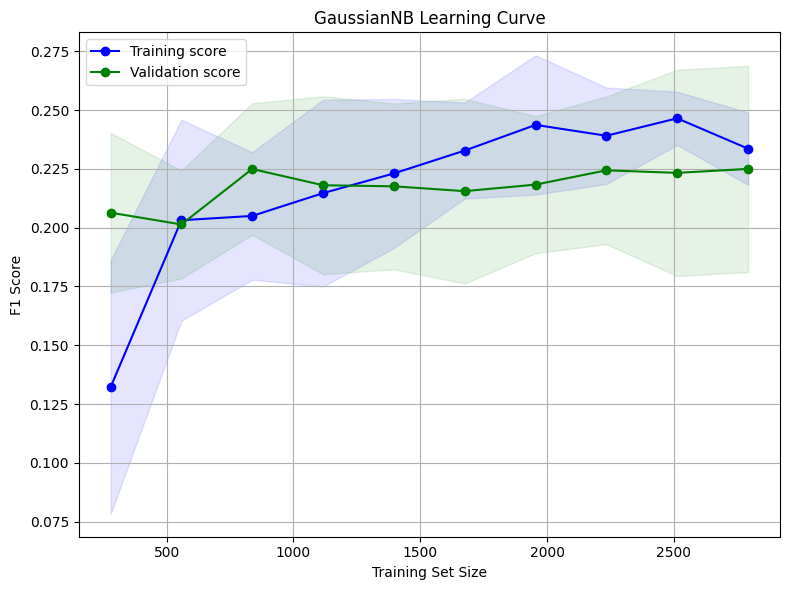

Number of features: 19
Means length: 19
Variances length: 19

Feature Means:
                           Feature      Mean
17     smoking_status_never smoked  0.759259
8                      gender_Male  0.660291
3                     hypertension  0.604736
18           smoking_status_smokes  0.503339
13         work_type_Self-employed  0.412265
4                    heart_disease  0.394961
1                avg_glucose_level  0.376873
11          work_type_Never_worked  0.209775
12               work_type_Private  0.194596
14              work_type_children  0.183364
9                     gender_Other  0.182149
6                   Residence_type  0.150880
15          smoking_status_Unknown  0.108682
2                              bmi  0.103238
16  smoking_status_formerly smoked  0.055556
7                    gender_Female  0.003643
10              work_type_Govt_job  0.003036
5                     ever_married  0.000304
0                              age -0.068201

Feature Variances:
   

In [29]:
pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", GaussianNB())])

param_dist = {"classifier__var_smoothing": np.logspace(0, -9, num=100)}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5),
    scoring="f1",
    n_jobs=-1,
    random_state=42,
)

print("Performing randomized search with cross-validation...")
random_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation AUC score: {random_search.best_score_:.3f}")

best_model = random_search.best_estimator_

print("\nEvaluating on test set...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Insurance", "Insurance"]
)

plot_learning_curve(
    best_model,
    X_train,
    y_train,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5),
    title="GaussianNB Learning Curve",
)

if hasattr(best_model.named_steps["classifier"], "theta_"):
    feature_names = get_feature_names(best_model.named_steps["preprocessor"])

    means = best_model.named_steps["classifier"].theta_[0]
    variances = best_model.named_steps["classifier"].var_[0]

    print(f"Number of features: {len(feature_names)}")
    print(f"Means length: {len(means)}")
    print(f"Variances length: {len(variances)}")

    means_df = pd.DataFrame({"Feature": feature_names, "Mean": means}).sort_values(
        "Mean", ascending=False
    )
    variances_df = pd.DataFrame(
        {"Feature": feature_names, "Variance": variances}
    ).sort_values("Variance", ascending=False)

    print("\nFeature Means:")
    print(means_df)
    print("\nFeature Variances:")
    print(variances_df)
else:
    print("\nFeature statistics not available for this model")

## Ensemble Models

### Random Forest
As seen below, the random forest gives a:
- *Positive Case Precision =  0.17*. This is a very poor figure
- *Positive Case Recall = 0.80*. This is a very good figure.
- *Positive Case F1 = 0.27.* This is a poor figure, but mostly due to the precision.

Here, the coefficients which are shown to hold the highest influence to be age, with the rest trailing quite far behind.

Performing randomized search with cross-validation...

Best parameters found:
{'classifier__n_estimators': 50, 'classifier__min_samples_split': 2, 'classifier__max_features': None, 'classifier__max_depth': 5, 'classifier__class_weight': 'balanced'}

Best cross-validation AUC score: 0.244

Evaluating on test set...

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       825
           1       0.17      0.80      0.28        49

    accuracy                           0.77       874
   macro avg       0.58      0.78      0.57       874
weighted avg       0.94      0.77      0.83       874


Test AUC: 0.827
Test Accuracy: 0.772


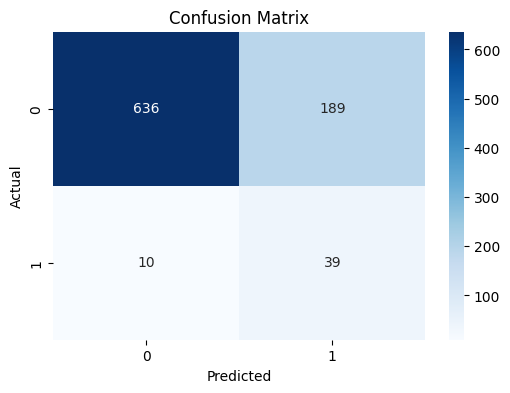

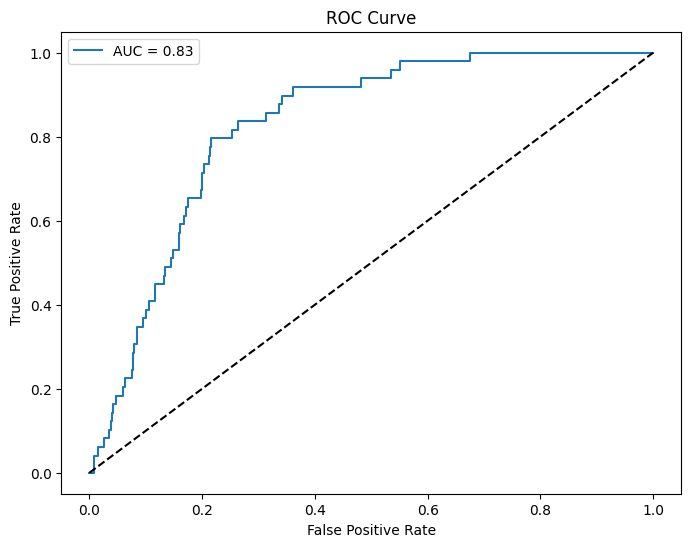

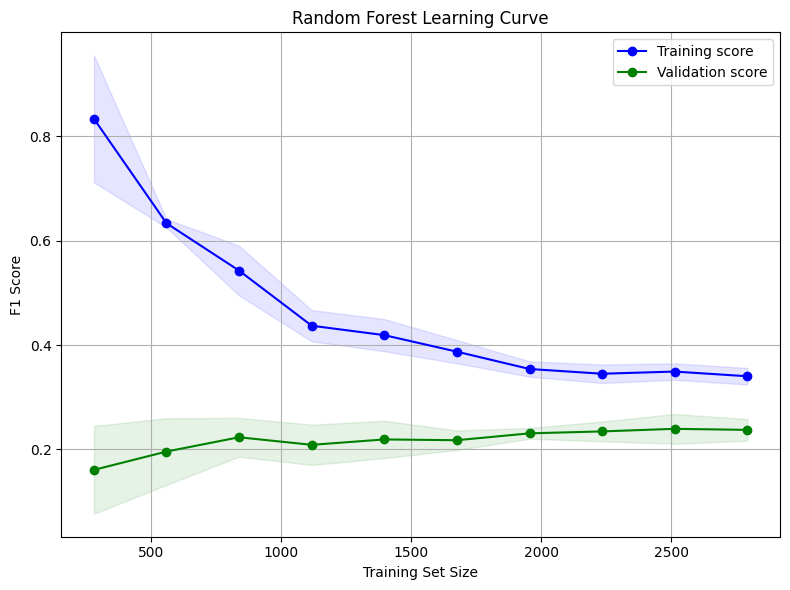


Feature Importances:
                           Feature    Importance
0                              age  6.762546e-01
1                avg_glucose_level  1.370009e-01
2                              bmi  1.104563e-01
13         work_type_Self-employed  2.406623e-02
14              work_type_children  7.669986e-03
9                     gender_Other  6.893795e-03
15          smoking_status_Unknown  6.339202e-03
12               work_type_Private  5.109794e-03
3                     hypertension  4.123232e-03
17     smoking_status_never smoked  3.977697e-03
18           smoking_status_smokes  3.789840e-03
11          work_type_Never_worked  3.553367e-03
8                      gender_Male  3.281162e-03
16  smoking_status_formerly smoked  2.962054e-03
6                   Residence_type  2.600660e-03
4                    heart_disease  1.921254e-03
5                     ever_married  2.678663e-16
7                    gender_Female  7.081382e-17
10              work_type_Govt_job  0.000000e+0

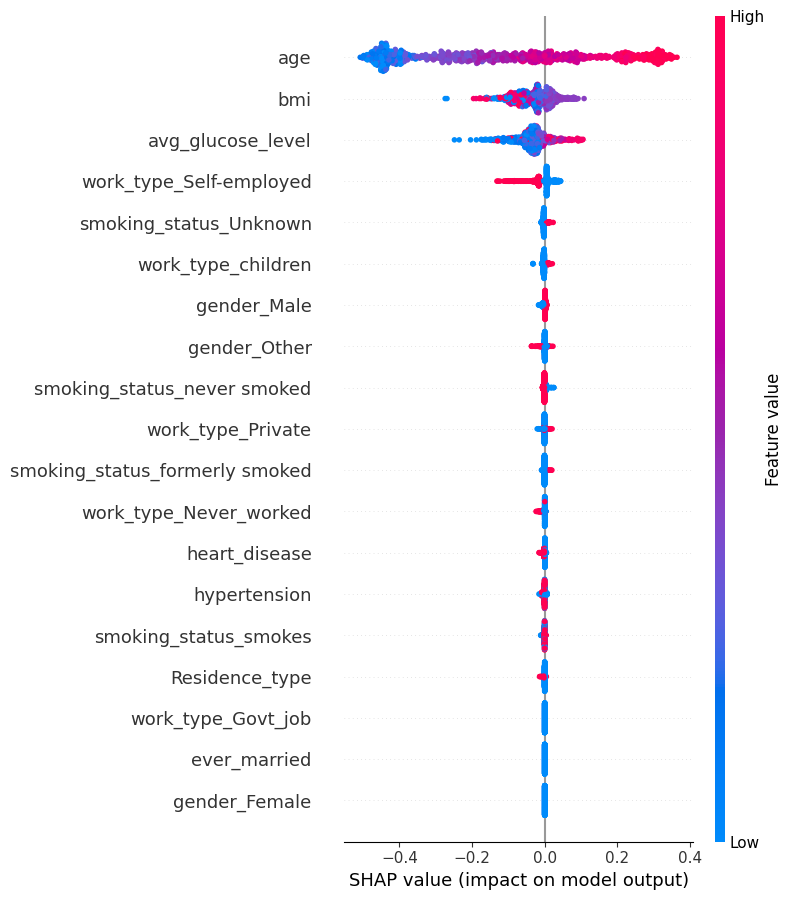

In [30]:
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

param_dist = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [None, 5, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__class_weight": ["balanced", None],
    "classifier__max_features": ["sqrt", "log2", None],
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5),
    scoring="f1",
    n_jobs=-1,
    random_state=42,
)

print("Performing randomized search with cross-validation...")
random_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation AUC score: {random_search.best_score_:.3f}")

best_model = random_search.best_estimator_

print("\nEvaluating on test set...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Insurance", "Insurance"]
)

plot_learning_curve(
    best_model,
    X_train,
    y_train,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5),
    title="Random Forest Learning Curve",
)

feature_names = get_feature_names(best_model.named_steps["preprocessor"])

importances = best_model.named_steps["classifier"].feature_importances_
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

print("\nFeature Importances:")
print(importance_df)

X_test_transformed = best_model.named_steps["preprocessor"].transform(X_test)

if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

feature_names = get_feature_names(best_model.named_steps["preprocessor"])

X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

explainer = shap.TreeExplainer(best_model.named_steps["classifier"])
shap_values = explainer.shap_values(X_test_df)

print(f"SHAP values shape: {np.shape(shap_values)}")
print(f"X_test_df shape: {X_test_df.shape}")

shap.summary_plot(shap_values[:, :, 1], X_test_df, feature_names=feature_names)

### XGBoost Model
As seen below, the XGBoost gives a:
- *Positive Case Precision =  0.18*. This is a very poor figure
- *Positive Case Recall = 0.80*. This is a very good figure.
- *Positive Case F1 = 0.30.* This is a poor figure, but mostly due to the precision.

Here, the coefficients which are shown to hold the highest influence to be age, with the rest trailing quite far behind.

I was particularly excited for this model, since the hyperparameter of scale_pos_weight is one that has been praised to work very well for ensuring good test results on the positive case. However, in this case it did not make the model run better than the others. In fact, I had to manually tune this parameter using a variety of methods (instead of the random search) to get it as high as it is.

In [31]:
counter = Counter(y_train)
neg, pos = counter[0], counter[1]
scale_pos_weight = neg / pos
scale_pos_weight

16.636363636363637

Performing randomized search with cross-validation...


C:\Users\david\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:32:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters found:
{'classifier__subsample': 0.6, 'classifier__scale_pos_weight': 16.636363636363637, 'classifier__n_estimators': 50, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.6}

Best cross-validation AUC score: 0.241

Evaluating on test set...

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       825
           1       0.18      0.80      0.30        49

    accuracy                           0.79       874
   macro avg       0.58      0.79      0.59       874
weighted avg       0.94      0.79      0.84       874


Test AUC: 0.841
Test Accuracy: 0.791


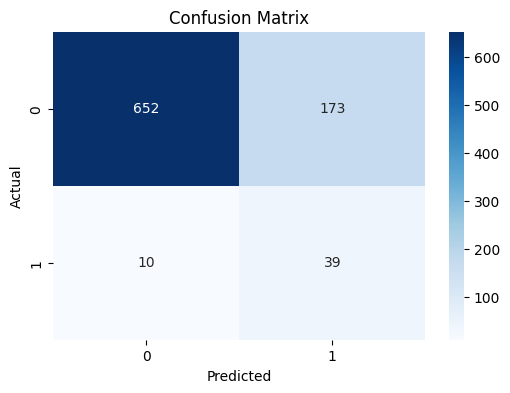

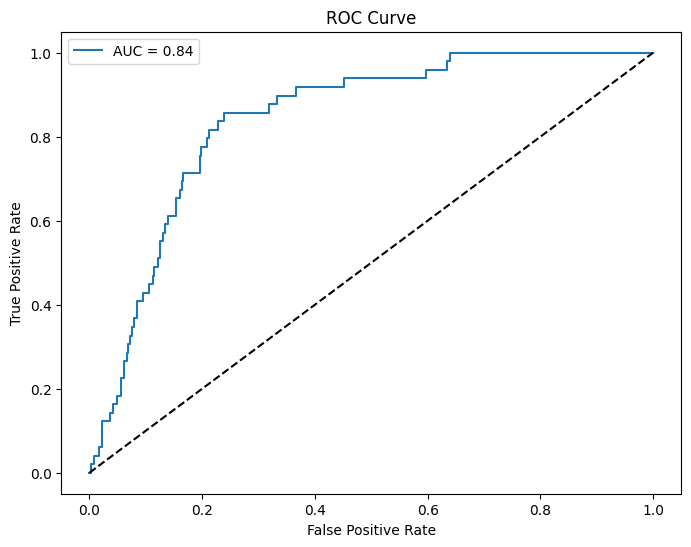

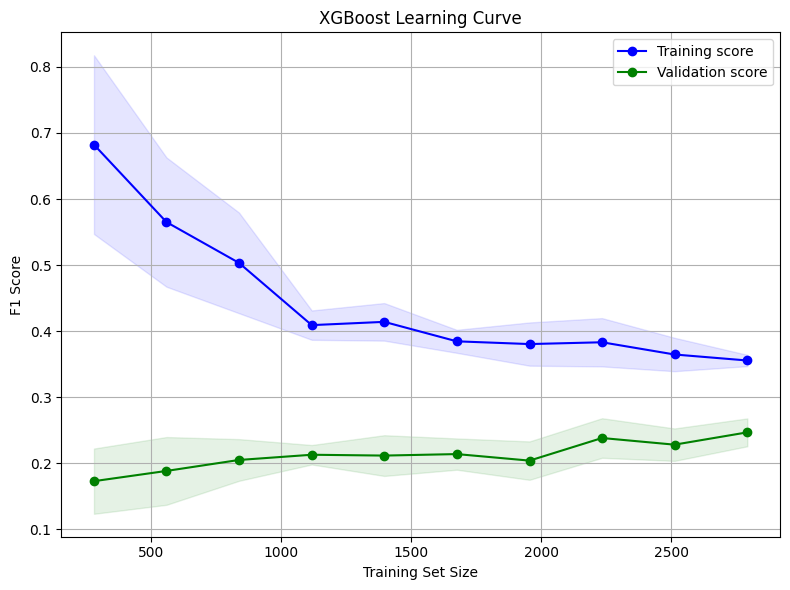


Feature Importances:
                           Feature  Importance
0                              age    0.237316
15          smoking_status_Unknown    0.113044
16  smoking_status_formerly smoked    0.111893
1                avg_glucose_level    0.064140
17     smoking_status_never smoked    0.063935
2                              bmi    0.063852
13         work_type_Self-employed    0.045108
12               work_type_Private    0.040921
8                      gender_Male    0.039388
3                     hypertension    0.038746
9                     gender_Other    0.038129
6                   Residence_type    0.034214
4                    heart_disease    0.032430
18           smoking_status_smokes    0.029172
11          work_type_Never_worked    0.027598
14              work_type_children    0.020113
10              work_type_Govt_job    0.000000
5                     ever_married    0.000000
7                    gender_Female    0.000000


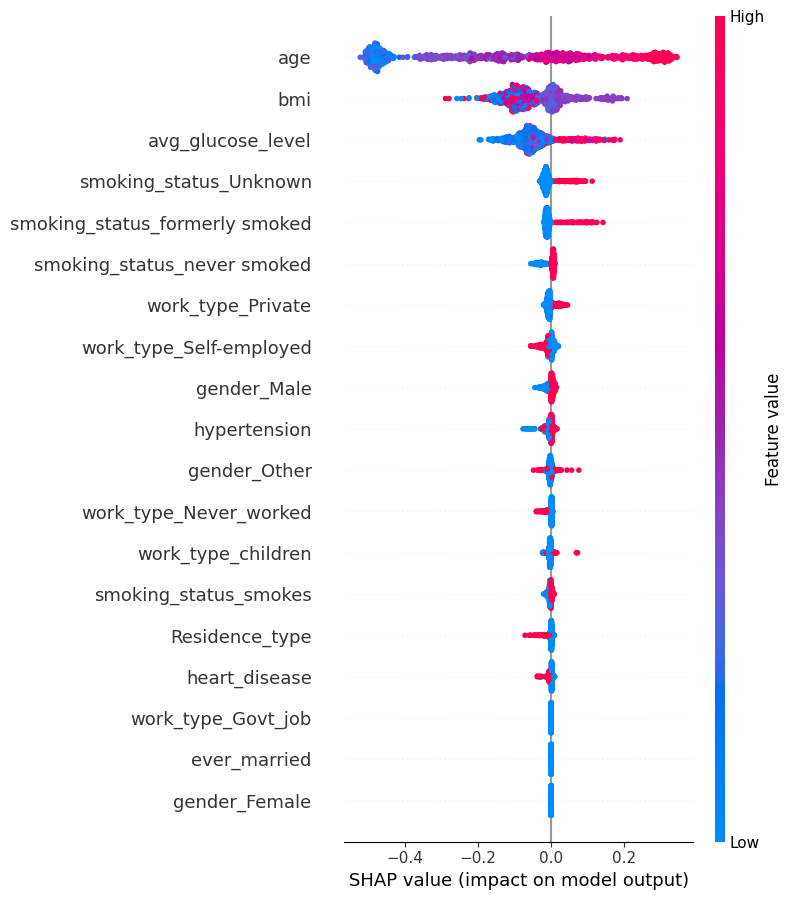

In [32]:
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            XGBClassifier(
                random_state=42, use_label_encoder=False, eval_metric="logloss"
            ),
        ),
    ]
)

param_dist = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [3, 5, 10, 20],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__subsample": [0.6, 0.8, 1.0],
    "classifier__colsample_bytree": [0.6, 0.8, 1.0],
    "classifier__scale_pos_weight": [16.636363636363637],
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5),
    scoring="f1",
    n_jobs=-1,
    random_state=42,
)

print("Performing randomized search with cross-validation...")
random_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation AUC score: {random_search.best_score_:.3f}")

best_model = random_search.best_estimator_

print("\nEvaluating on test set...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Stroke", "Stroke"]
)

plot_learning_curve(
    best_model,
    X_train,
    y_train,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5),
    title="XGBoost Learning Curve",
)

feature_names = get_feature_names(best_model.named_steps["preprocessor"])
importances = best_model.named_steps["classifier"].feature_importances_

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

print("\nFeature Importances:")
print(importance_df)

X_test_transformed = best_model.named_steps["preprocessor"].transform(X_test)

explainer = shap.TreeExplainer(best_model.named_steps["classifier"])
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

### LightGBM Model
As seen below, the LightGBM gives a:
- *Positive Case Precision =  0.16*. This is a very poor figure
- *Positive Case Recall = 0.59*. This is a decent figure.
- *Positive Case F1 = 0.25.* This is a poor figure, but mostly due to the precision.

It is not surprising that the results are quite bad here, as LightGBM is a model that typically needs a lot of data points to really be effective.

Here, the coefficients which are shown to hold the highest influence to be age, with the rest trailing quite far behind.

Performing randomized search with cross-validation...
[LightGBM] [Info] Number of positive: 3294, number of negative: 3294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3690
[LightGBM] [Info] Number of data points in the train set: 6588, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       825
           1       0.16      0.59      0.25        49

    accuracy                           0.81       874
   macro avg       0.57      0.71      0.57       874
weighted avg       0.93      0.81      0.85       874


Test AUC: 0.823
Test Accuracy: 0.805


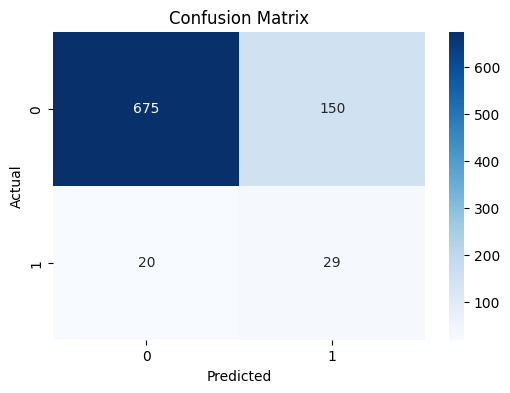

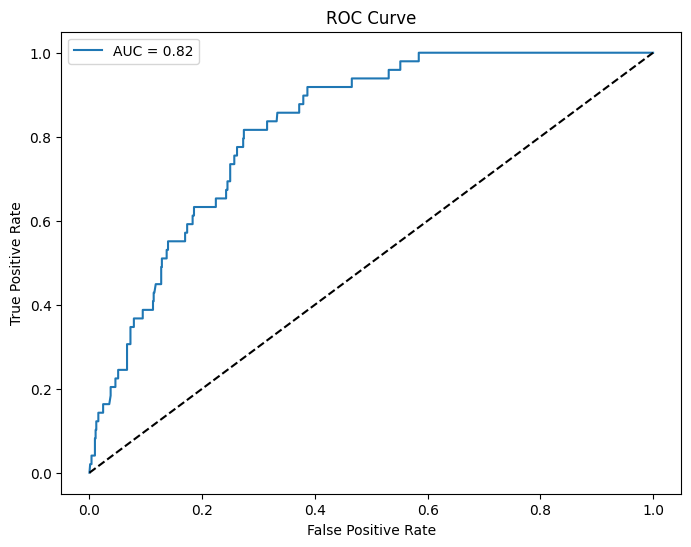

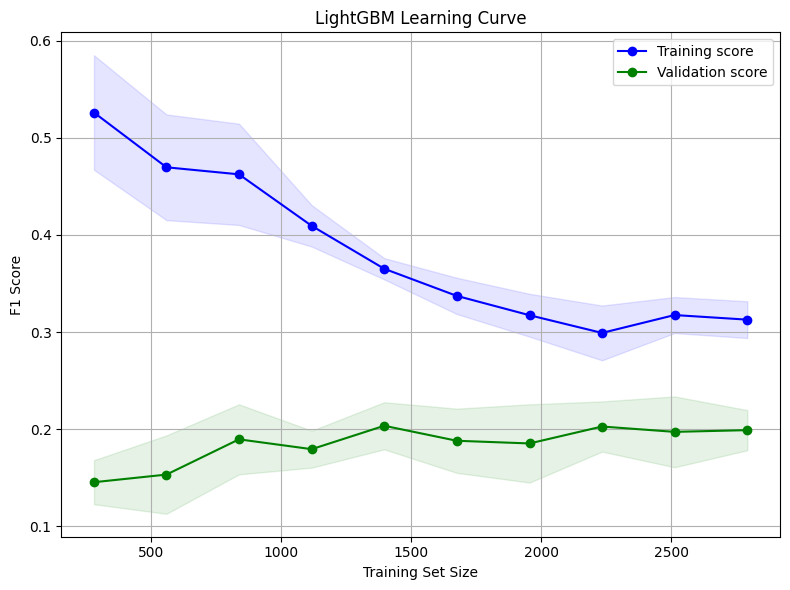


Feature Importances:
                           Feature  Importance
0                              age         249
1                avg_glucose_level         203
2                              bmi         149
18           smoking_status_smokes         137
8                      gender_Male          98
16  smoking_status_formerly smoked          90
14              work_type_children          72
17     smoking_status_never smoked          65
15          smoking_status_Unknown          59
13         work_type_Self-employed          53
9                     gender_Other          52
3                     hypertension          43
12               work_type_Private          37
11          work_type_Never_worked          35
6                   Residence_type          26
4                    heart_disease          16
10              work_type_Govt_job           0
5                     ever_married           0
7                    gender_Female           0


C:\Users\david\anaconda3\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


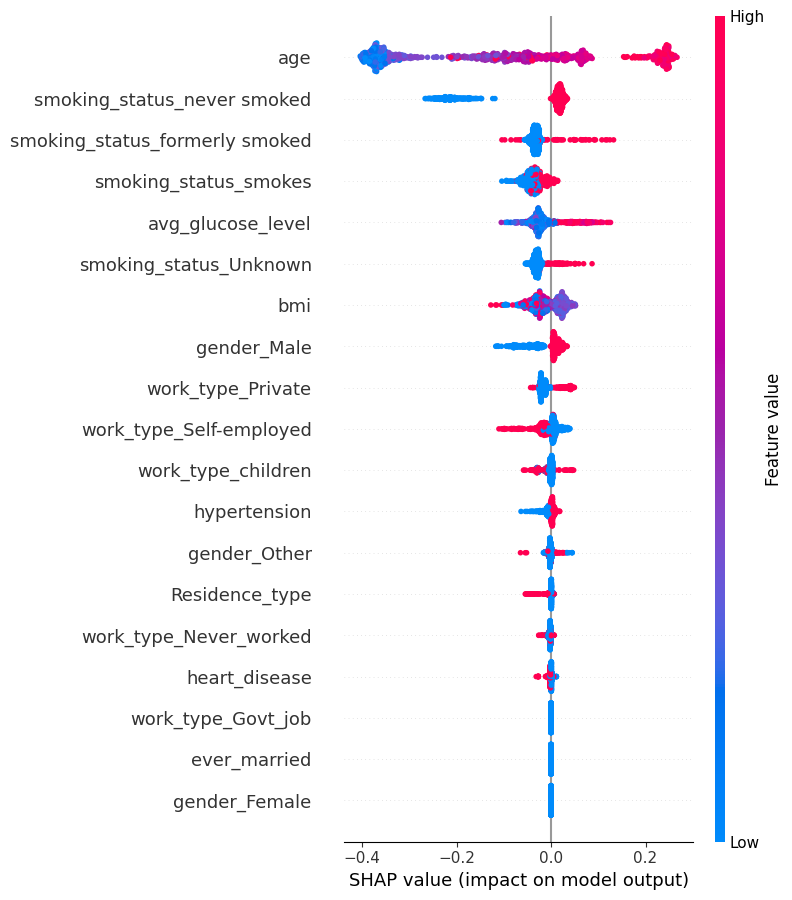

In [33]:
smote = SMOTE(random_state=42)

pipeline = ImbPipeline(
    [
        ("preprocessor", preprocessor),
        ("smote", smote),
        ("classifier", lgb.LGBMClassifier(random_state=42)),
    ]
)

param_dist = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [-1, 5, 10, 20],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__num_leaves": [31, 50, 100],
    "classifier__subsample": [0.6, 0.8, 1.0],
    "classifier__colsample_bytree": [0.6, 0.8, 1.0],
    "classifier__class_weight": [None, "balanced"],
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5),
    scoring="f1",
    n_jobs=-1,
    random_state=42,
)

print("Performing randomized search with cross-validation...")
random_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation AUC score: {random_search.best_score_:.3f}")

best_model = random_search.best_estimator_

print("\nEvaluating on test set...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Stroke", "Stroke"]
)

plot_learning_curve(
    best_model,
    X_train,
    y_train,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5),
    title="LightGBM Learning Curve",
)

feature_names = get_feature_names(best_model.named_steps["preprocessor"])
importances = best_model.named_steps["classifier"].feature_importances_

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

print("\nFeature Importances:")
print(importance_df)

X_test_transformed = best_model.named_steps["preprocessor"].transform(X_test)

explainer = shap.TreeExplainer(best_model.named_steps["classifier"])
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

### Voting Model
Next, I combine the models that had the scores into a soft voting model to see if this will produce better results. Moreover, I try to cover different methodologies in doing so, such as by combining a logistic regression with a decision tree, so that it can hopefully cover the gaps of one another.

As seen below, the voting model gives a:
- *Positive Case Precision =  0.17*. This is a very poor figure
- *Positive Case Recall = 0.67*. This is an okay figure.
- *Positive Case F1 = 0.27.* This is a poor figure, but mostly due to the precision.

Ultimately, the results seem to be poorer, and as such hardly constitute a realistic competitor.

Training voting classifier...

Evaluating on test set...

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       825
           1       0.17      0.67      0.27        49

    accuracy                           0.79       874
   macro avg       0.57      0.74      0.57       874
weighted avg       0.93      0.79      0.85       874


Test AUC: 0.836
Test Accuracy: 0.794


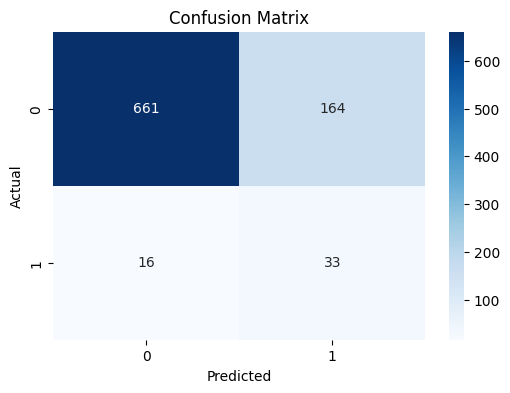

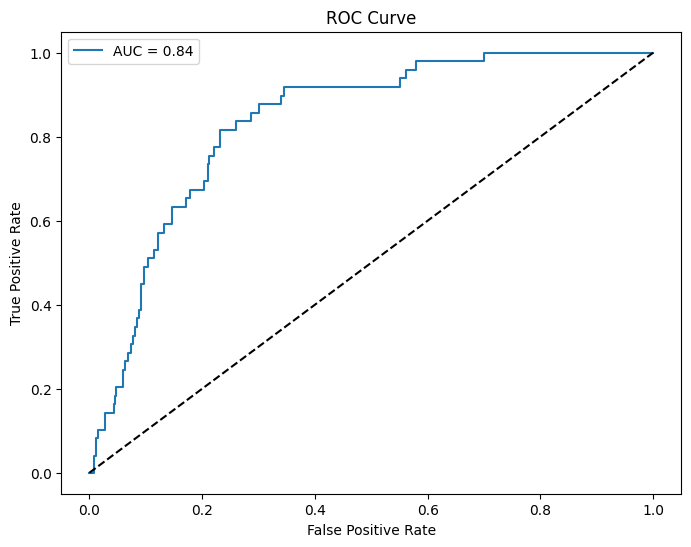

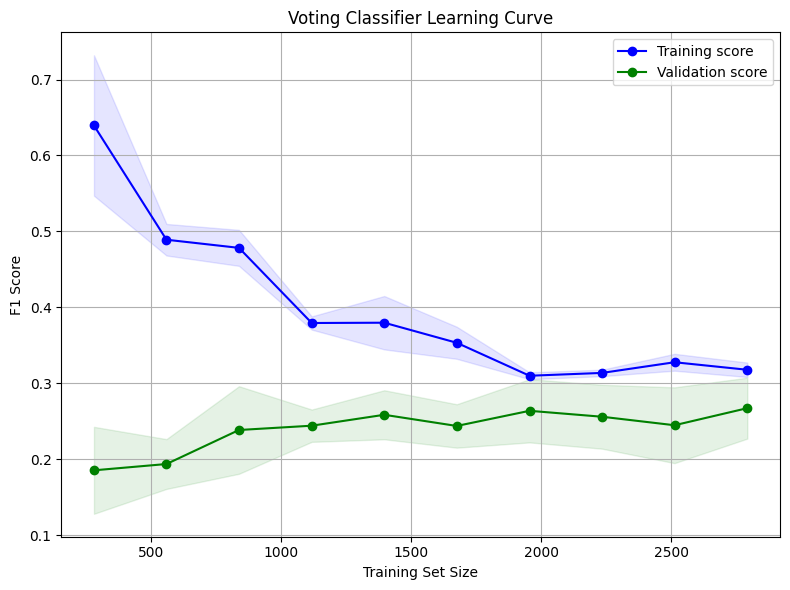

In [34]:
logistic = LogisticRegression(
    C=np.float64(0.5622117123602399),
    penalty="l1",
    solver="liblinear",
    random_state=42,
    max_iter=1000,
    class_weight="balanced"
)

decision_tree = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=2,
    min_samples_split=13,
    class_weight="balanced",
    random_state=42
)

svm = SVC(
    C=82.88375091519293,
    kernel="linear",
    degree=2,
    gamma="auto",
    class_weight="balanced",
    probability=True,
    random_state=42,
)

random_forest = RandomForestClassifier(
    n_estimators=50,
    max_depth=5,
    min_samples_split=2,
    max_features=None,
    class_weight="balanced",
    random_state=42,
)

voting_clf = VotingClassifier(
    estimators=[
        ("lr", logistic),
        ("dt", decision_tree),
        ("svc", svm),
        ("rf", random_forest),
    ],
    voting="soft",
    weights=None,
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", voting_clf)
])

print("Training voting classifier...")
pipeline.fit(X_train, y_train)

print("\nEvaluating on test set...")
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Stroke", "Stroke"]
)

plot_learning_curve(
    pipeline,
    X_train,
    y_train,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5),
    title="Voting Classifier Learning Curve",
)

### Summary of the Best
The best performing models are as follows:

1. **Logistic Regression**. A recall of 0.86 and precision of 0.15 of the positive case (i.e. the presence of a stroke) - with the F1 of this being 0.25.
2. **Decision Tree**. A recall of 0.88 and precision of 0.13 of the positive case (i.e. the presence of a stroke) - with the F1 of this being 0.23.
3. **SVC**. A recall of 0.90 and precision of 0.15 of the positive case (i.e. the presence of a stroke) - with the F1 of this being 0.26.
4. **Random Forest**. A recall of 0.80 and precision of 0.17 of the positive case (i.e. the presence of a stroke) - with the F1 of this being 0.28.
5. **XGBoost**. A recall of 0.80 and precision of 0.18 of the positive case (i.e. the presence of a stroke) - with the F1 of this being 0.30.

The SVC forest model has a slightly higher performance on the key metrics, and as such is the highest-performing model. However, for the intents and purposes of this paper, which I assume to be the serving of some medicinal-related end, the increased explanability of a simpler model is ideal. As such I crown the logistic model as the best-fitting model for this analysis, and will continue to deploy this model, as it comes at only a very small marginal cost in recall.

# Deploying the Model
First I rerun the Logistic regression with the final pipeline, to ensure all things look fine.

Training final Logistic Regression model with best hyperparameters...


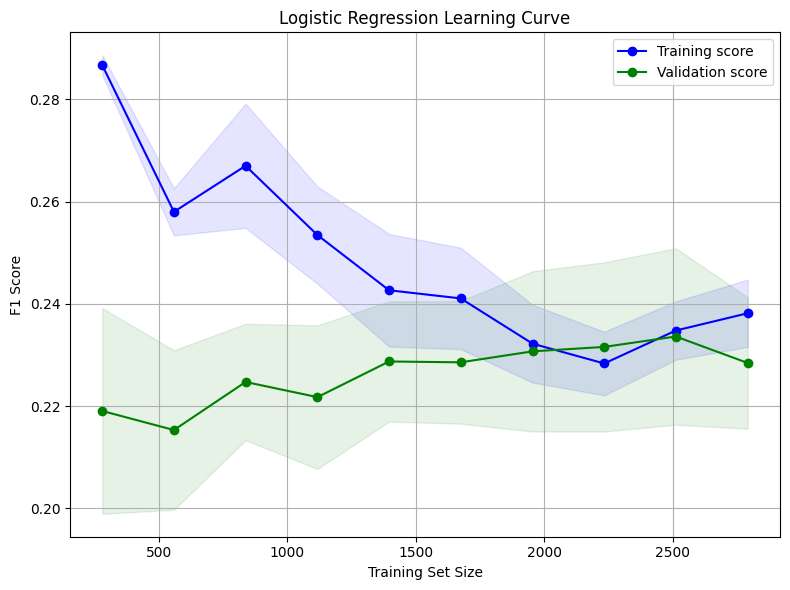


Prediction distribution:
0    586
1    288
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       825
           1       0.15      0.86      0.25        49

    accuracy                           0.71       874
   macro avg       0.57      0.78      0.53       874
weighted avg       0.94      0.71      0.79       874


Test AUC: 0.849
Test Accuracy: 0.711


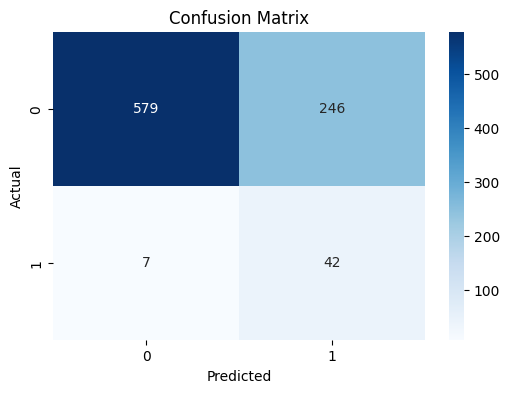

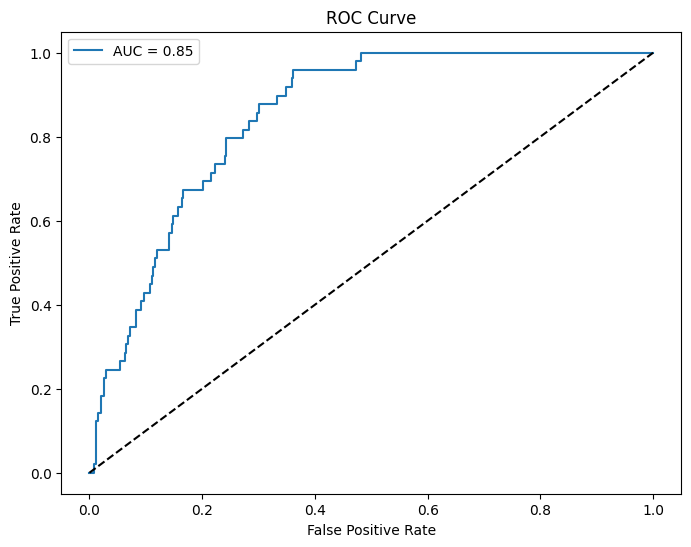


Feature Coefficients:
                           Feature  Coefficient
0                              age     2.223622
15          smoking_status_Unknown     0.361562
16  smoking_status_formerly smoked     0.248004
8                      gender_Male     0.180370
14              work_type_children     0.152028
1                avg_glucose_level     0.139821
18           smoking_status_smokes     0.056837
2                              bmi     0.032461
3                     hypertension     0.000000
6                   Residence_type     0.000000
5                     ever_married     0.000000
12               work_type_Private     0.000000
17     smoking_status_never smoked     0.000000
7                    gender_Female     0.000000
10              work_type_Govt_job     0.000000
4                    heart_disease    -0.134040
9                     gender_Other    -0.200517
11          work_type_Never_worked    -0.205814
13         work_type_Self-employed    -0.351763

Running SHAP ana

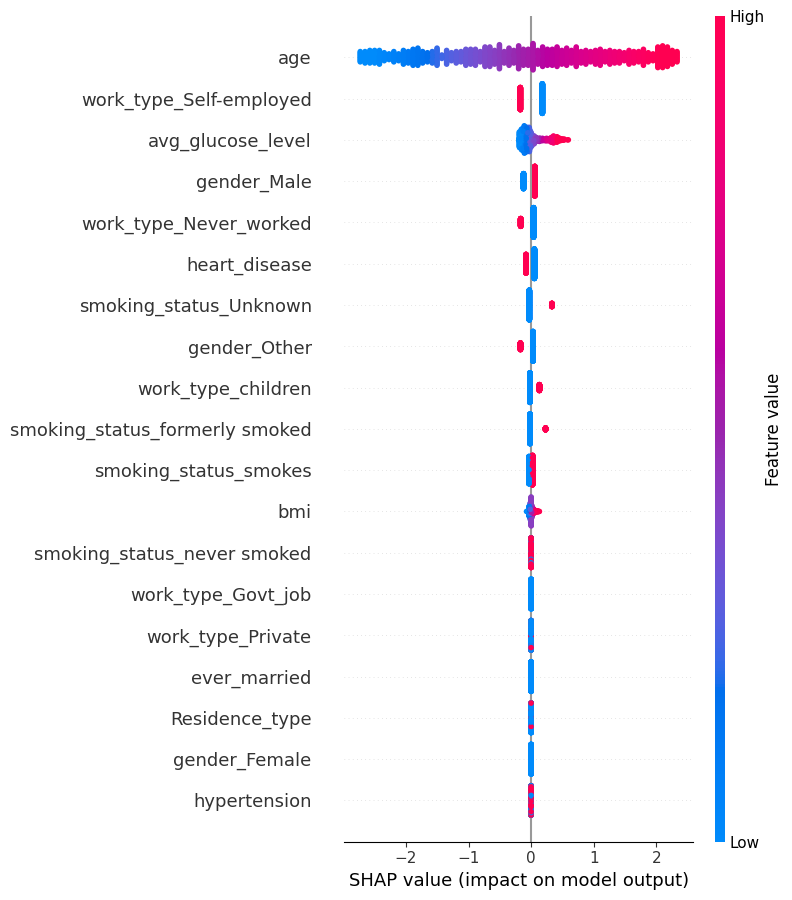

In [35]:
final_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            LogisticRegression(
                C=0.5622117123602399,
                penalty="l1",
                solver="liblinear",
                class_weight="balanced",
                random_state=42,
                max_iter=1000,
            ),
        ),
    ]
)

print("Training final Logistic Regression model with best hyperparameters...")
final_pipeline.fit(X_train, y_train)

plot_learning_curve(
    final_pipeline,
    X_train,
    y_train,
    scoring="f1",
    title="Logistic Regression Learning Curve",
)

y_pred = final_pipeline.predict(X_test)
print("\nPrediction distribution:")
print(pd.Series(y_pred).value_counts())

y_proba = final_pipeline.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Stroke", "Stroke"]
)

feature_names = get_feature_names(final_pipeline.named_steps["preprocessor"])
coefficients = final_pipeline.named_steps["classifier"].coef_[0]
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
print("\nFeature Coefficients:")
print(coef_df.sort_values("Coefficient", ascending=False))

print("\nRunning SHAP analysis...")
X_test_transformed = final_pipeline.named_steps["preprocessor"].transform(X_test)

explainer = shap.LinearExplainer(
    final_pipeline.named_steps["classifier"], X_test_transformed
)
shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

### Saving it

In [36]:
joblib.dump(final_pipeline, "best_model.pkl")

['best_model.pkl']

In [37]:
with open("feature_columns.json", "w") as f:
    json.dump(list(X_train.columns), f)

# Conclusion
In conclusion, the inferential analysis showed that only two variables had a significant effect on stroke, namely age and average glucose level. Of these, age by far had the strongest coefficient. This variable was also indicated as being the most significant in the various machine learning algorithms that I ran and built. Consequently, this confirms only the first hypothesis, which was that age would be the most impactful significant predictor. In the inferential analysis, it should be mentioned that a few assumptions behind the logistic regression were violated. However, while some steps could be taken to remediate this, this is not pursued here, as the chief aim of the analysis was the machine learning component.
To that regard, I ran a variety of different models, namely a logistic regression, decision tree, SVC, Naive Bayes, random forest, XGBoost, LightGBM, and a voting classifier. I stuck to these, as these are the models I understand more thoroughly. As such, while there may be some models which could have better performance, I opted to focus on models I feel more capable of explaining. Ultimately, the model which I deemed the most fitting was the logistic regression, which I then deployed using joblib and flask. This was more a proof of concept of deployment, and if it was to be distributed on a more comprehensive scale, tools for containerization and/or web deployment could also be utilised. Throughout, the issue of the skewed dataset continued to manifest as a challenge, as the positive case in the binary target variable (i.e., the existence of a stroke) was very low in number. As a consequence, this often resulted in a poor evaluation of the prediction of this case. Consequently, I used tool like balanced class weights, and in one case SMOTE (though hesitantly, due to the majority of binary values), to better effect. Through this I was able to maximize the recall, albeit accompanied by a very low precision, and at the cost of performance of the negative case. However, as I imagine this serving a medical use-case, I figured the ability to actually predict a stroke to be of more use, and for the likely preventative care scope that this implies, I also figured that the ability to capture as high a degree of these positive cases would be most important (i.e., recall).

Things to be improved:
- **More data**. Given the very low amount of positive cases, this makes it hard to reliably predict this case. Furthermore, with many of the features only occupying a binary scale, this makes tools like SMOTE unreliable, and any oversampling technique to more so increase the likelihood of overfitting. As such, the access to a higher, as well as deeper features, would likely improve this model.
- **More models**. Some models might perhaps prove more efficient. As mentioned, I stuck to the ones I knew, as I figured these to be more valid for my case.
- **More class handling**. As mentioned, the class imbalance was indeed a struggle, but some models, such as a BalancedRandomForest or EasyEnsemble contain tools to help combat this. For this analysis, I stuck to the models we have learned for this course, but perhaps some time invested into understanding these would prove useful.
- **More checking for anomalous data**. There could be some data throwing the performance off, such as the long upper tail of the 'bmi' model. Perhaps the cutting of this feauture to center results more would give better performance. The use of an ECDF graph, as opposed to a histogram, also would have been beneficial for this purpose.
- **A different data imputation**. I used the mean value for the bmi column, but perhaps something like an unsupervised clustering method or KNN would give more accurate results, which in turn might have improved the performance of models
- **A higher degree of automation**. For example, the voting model uses manual inputs for the model hyperparameters. In a real case scenario, this could be updated so that in a post-deployment phase the model would not become obsolete by virtue of having outdated hyperparameters. GitHub Actions, for example, could be used to a good extent here to maximize this ability.
- **More investigation into false predictions**. In a real scenario, it would have also been beneficial to look into the false predictions of the different models to try to get an understanding of which data cases the model typically misclassifies. This could have both given insights into how to better structure/clean the data, as well as practical advice for stakeholders on when the model should not be used.
- **Testing for multicollinearity after standardization**. While this is not a great cause of concern in this analysis, as very few steps are taken after standardization, it is perhaps better practice to do so, as smaller data transformations can create differences in tests like multicollinearity.
- **Deployment Readiness**. More advanced models of deployment could be deployed to better serve a function. Knowing the context/scope of a project would help specify a better solution. For example, the usage of the FAST API would have given more flexibility and scalability.
- **Better treatment and visualition of outliers**. I could have experimented with percentiles, rules based on ECDF graphs, standard deviations, etc.
